<a href="https://colab.research.google.com/github/lixali/intro_to_ML_homework_practice/blob/main/5_hw_voter_classification_solution_s21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Voter classification using exit poll data


This is a solution notebook for Summer 2021.

In this notebook, we will explore the problem of voter classification.

Given demographic data about a voter and their opinions on certain key issues, can we predict their vote in the 2016 U.S. presidential election? We will attempt this using a K nearest neighbor classifier.

In the first part of this notebook, I will show you how to train and use a K nearest neighbors classifier for this task. In the next part of the notebook, you will try to improve the basic model for better performance.


## Import libraries

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import nan_euclidean_distances

We will need to install a library that is not in the default Colab environment, which we can install with `pip`:

In [ ]:
!pip install category_encoders

In [ ]:
import category_encoders as ce

## Load data


The data for this notebook comes from the [U.S. National Election Day Exit Polls](https://ropercenter.cornell.edu/exit-polls/us-national-election-day-exit-polls).

Here's a brief description of how exit polls work. 
 
Exit polls are conducted by Edison Research on behalf of a consortium of media organizations.

First, the member organizations decide what races to cover, what sample size they want, what questions should be asks, and other details. Then, sample precincts are selected, and local interviewers are hired and trained. Then, at those precincts, the local interviewer approaches a subset of voters as they exit the polls (for example, every third voter, or every fifth voter, depending on the required sample size).
 
When a voter is approached, they are asked if they are willing to fill out a questionnaire. Typically about 40-50% agree. (For those that decline, the interviewer visually estimates their age, race, and gender, and notes this information, so that the response rate by demographic is known and responses can be weighted accordingly in order to be more representative of the population.)
 
Voters that agree to participate are then given an form with 15-20 questions. They fill in the form (anonymously), fold it, and put it in a small ballot box.
 
Three times during the day, the interviewers will stop, take the questionnaires, compile the results, and call them in to the Edison Research phone center.  The results are reported immediately to the media organizations that are consortium members.
 
In addition to the poll of in-person voters, absentee and early voters (who are not at the polls on Election Day) are surveyed by telephone.

The exit poll data is not freely available on the web, but is available to those with institutional membership. You will be able to use your NYU email address to create an account with which you can download the exit poll data.

To get the data, visit [the Roper Center website](https://persistent.library.nyu.edu/arch/NYU02495). Click on the user icon in the top right of the page, and choose "Log in".

For "Your Affiliation", choose "New York University".

Then, choose "Register" (highlighted in yellow below).

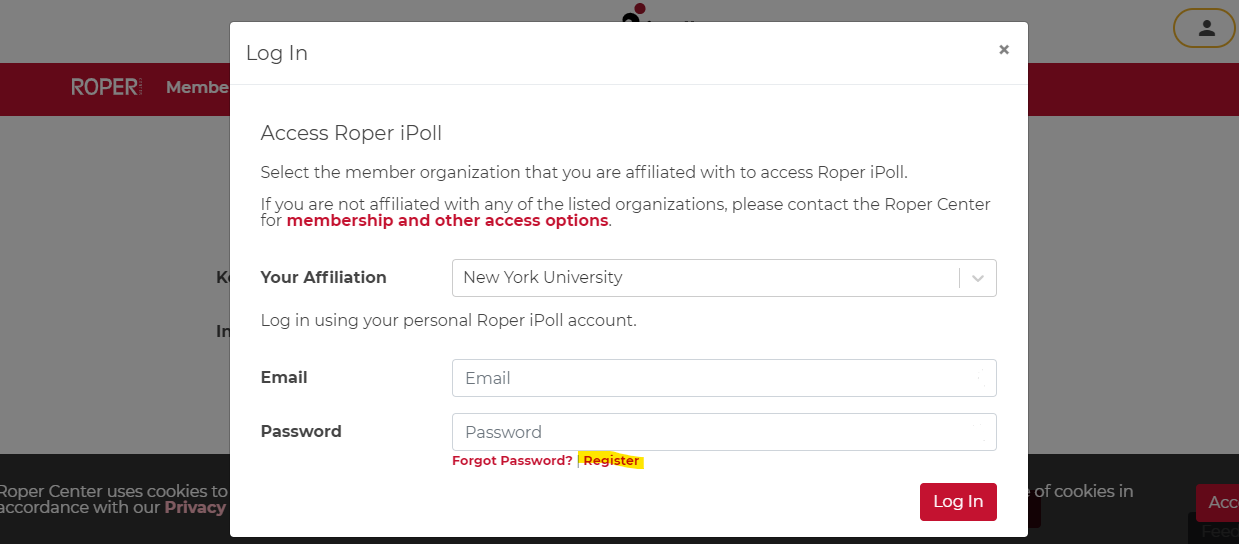

Enter your NYU email address (highlighted in yellow below) and then click "Register".

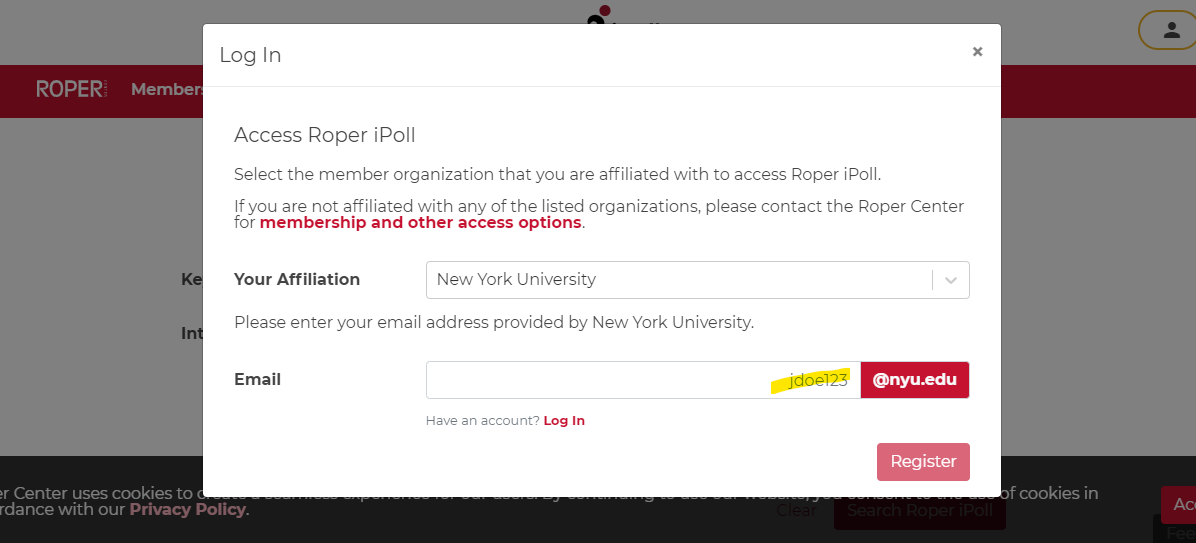

You will get an email at your NYU email address with the subject "Roper iPoll Account Registration". Open the email and click "Confirm Account" to create a password and finish your account registration.

Once you have completed your account registration, log in to Roper iPoll by clicking the user icon in the top right of the page, choosing "Log in", and entering your NYU email address and password.

Then, open the Study Record for the [2016 National Election Day Exit Poll](https://ropercenter.cornell.edu/ipoll/study/31116396).

Click on the "Downloads" tab, and then click on the CSV data file (highlighted in the image below).

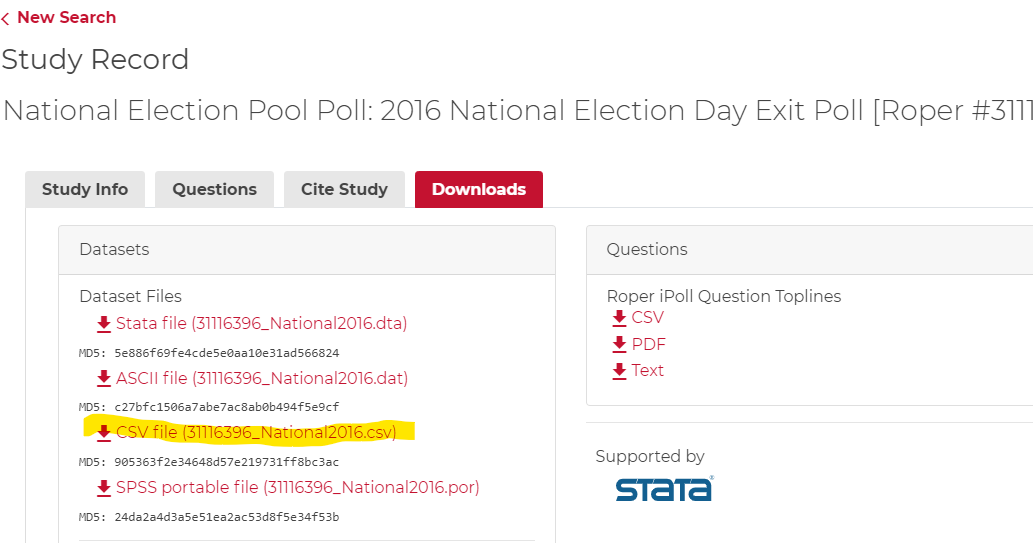

Accept the terms (click "Accept terms") and the file will be downloaded to your computer.

After you download the CSV file, scroll down a bit until you see the "Study Documentation, Questionnaire and Codebooks" PDF file. Download this file as well.

To get the data into Colab, run the following cell. Upload the CSV file you just downloaded (`31116396_National2016.csv`) to your Colab workspace. Wait until the uploaded has **completely** finished - it may take a while, depending on the quality of your network connection.


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 31116396_National2016.csv to 31116396_National2016.csv
User uploaded file "31116396_National2016.csv" with length 26283642 bytes


Then, use the `read_csv` function in `pandas` to read in the file. 

Also use `head` to view the first few rows of data and make sure that everything is read in correctly.

In [ ]:
df = pd.read_csv('31116396_National2016.csv')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,AGE60,AGE65,AGEBLACK,AGEBYRACE,AGEBYRACE08,ATTEND16,ATTEND16B,ATTREL,BACKSIDE,BORNCITIZEN,BREAK12,BREAK12A,BREAK12B,BRNAGAIN,CALL,CDNUM,CHIEF16,CLINHONEST,CLINTONEMAIL,CLINTONEMAILB,CLINTONWINGEN,CLINTONWINGENB,COUNT2,COUNTACC,CUBAN3,DESCRIBP12,EDUC12R,EDUCCOLL,EDUCHS,EDUCWHITE,...,RACE2B,RACEAI,REGION,REL4,REL5,RELIGN10,RELWHITE,SEX,SEXBYRACE,SEXWED,SIZEPLAC,SIZEPLC3,SPANISHQ,SPLITTICKET,STANUM,SUBURBWHITE,SUPREME16,SUPREME16B,TELEPOLL,TEMPCLINTON,TEMPERAMENT16,TEMPTRUMP,TIME16,TIME16MONTH,TIME16WEEK,TRACK,TRADE16,TRUMPHONEST,TRUMPWINGEN,TRUMPWINGENB,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
0,135355,Hillary Clinton,The Democratic candidate,6.530935,,18-29,18-29,18-24,18-44,18-49,18-29,18-24,Non-Black 18-29,Latino 18-29,Latino 18-29,,,,Complete,,,,,,,30,,,,,,,,,,,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Hispanic/Latino,West,,,,,Female,Latino women,Married women,Suburbs,Suburbs,English,,California,Other,,,Telephone survey,,,,In October,In the last month,Before that,,,,,,,,,Version 1,,,No,,,
1,135356,Hillary Clinton,The Democratic candidate,6.479016,,18-29,18-29,25-29,18-44,18-49,18-29,25-29,Non-Black 18-29,Latino 18-29,Latino 18-29,,,,Complete,,,,,,,44,,,,,,,,,,,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Hispanic/Latino,West,,,,,Male,Latino men,Married men,Suburbs,Suburbs,English,,California,Other,,,Telephone survey,,,,In October,In the last month,Before that,,,,,,,,,Version 1,,,No,,,
2,135357,Hillary Clinton,The Democratic candidate,8.493230,,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,,,,Complete,,,,,,,6,,,,,,,,,,,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Asian,West,,,,,Male,All other races,Married men,"Cities 50,000-500,000","Cities over 50,000",English,,California,Other,,,Telephone survey,,,,In September,Before that,Before that,,,,,,,,,Version 1,,,No,,,
3,135358,Hillary Clinton,The Democratic candidate,3.761814,,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,,,,Complete,,,,,,,11,,,,,,,,,,,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Other,West,,,,,Female,All other races,Non married women,Suburbs,Suburbs,English,,California,Other,,,Telephone survey,,,,In the last week,In the last month,In the last week,,,,,,,,,Version 1,,,No,,,
4,135359,Hillary Clinton,The Democratic candidate,3.470473,,45-65,30-59,45-49,45+,18-49,45-59,40-49,Black 45-59,Black 45-59,Black 45-64,,,,Complete,,,,,,,37,,,,,,,,,,,Postgraduate study,College graduate,More than High school graduate,Non white college degree,...,Non-white,Black,West,,,,,Female,Black women,Non married women,"Cities over 500,000","Cities over 50,000",English,,California,Other,,,Telephone survey,,,,Before that,Before that,Before that,,,,,,,,,Version 1,,,No,,,


## Prepare data

Survey data can be tricky to work with, because surveys often "branch"; the questions that are asked depends on a respondent's answers to other questions.

In this case, different respondents fill out different versions of the survey. 




Review pages 7-11 of the "Study Documentation, Questionnaire, and Codebooks" PDF file you downloaded earlier, which shows the five different questionnaire versions used for the 2016 exit polls. 



![Exit poll versions](https://raw.githubusercontent.com/ffund/ml-notebooks/master/notebooks/images/exit-poll-survey-versions.png)

In [ ]:
df['VERSION'].value_counts()

Version 2    5126
Version 1    5094
Version 3    4980
Version 4    4919
Version 5    4915
Name: VERSION, dtype: int64

In a red box next to each question, you can also see the name of the variable (column name) that the respondent's answer will be stored in.

Because each respondent answers different questions, for each row in the data, only some of the columns - the columns corresponding to questions included in that version of the survey - have data.

### Missing data

Since each respondent only saw a subset of questions, we expect to see missing values in each column.

However, if we look at the **count** of values in each column, we see that there are no missing values - every column has the full count!

In [ ]:
df.describe(include='all')

,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,AGE60,AGE65,AGEBLACK,AGEBYRACE,AGEBYRACE08,ATTEND16,ATTEND16B,ATTREL,BACKSIDE,BORNCITIZEN,BREAK12,BREAK12A,BREAK12B,BRNAGAIN,CALL,CDNUM,CHIEF16,CLINHONEST,CLINTONEMAIL,CLINTONEMAILB,CLINTONWINGEN,CLINTONWINGENB,COUNT2,COUNTACC,CUBAN3,DESCRIBP12,EDUC12R,EDUCCOLL,EDUCHS,EDUCWHITE,...,RACE2B,RACEAI,REGION,REL4,REL5,RELIGN10,RELWHITE,SEX,SEXBYRACE,SEXWED,SIZEPLAC,SIZEPLC3,SPANISHQ,SPLITTICKET,STANUM,SUBURBWHITE,SUPREME16,SUPREME16B,TELEPOLL,TEMPCLINTON,TEMPERAMENT16,TEMPTRUMP,TIME16,TIME16MONTH,TIME16WEEK,TRACK,TRADE16,TRUMPHONEST,TRUMPWINGEN,TRUMPWINGENB,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
count,25034.000000,25034,25034,25034.000000,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034.000000,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,...,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034,25034
unique,NaN,7,5,NaN,5,5,4,9,3,3,5,7,9,14,14,5,3,6,2,3,6,4,4,3,4,NaN,4,4,6,4,6,4,4,6,4,5,5,3,3,5,...,3,7,4,5,6,9,6,3,8,5,5,3,3,6,51,4,6,4,2,4,6,4,7,4,4,4,5,4,6,4,6,4,3,5,3,7,3,3,3,4
top,NaN,Hillary Clinton,The Democratic candidate,NaN,,45-65,30-59,50-59,45+,18-49,45-59,50-64,Non-Black 45-59,White 60+,White 45-64,,,,Complete,,,,,,Call 1,NaN,,,,,,,,,,,Some college/assoc. degree,No college degree,More than High school graduate,White college degree,...,White,White,South,,,,,Female,White women,,Suburbs,Suburbs,,,California,Other,,,Election day exit poll,,,,,,,,,,,,,,,Version 2,,,,,,
freq,NaN,12126,12041,NaN,15568,9746,13697,5071,14436,12836,7490,7327,6438,5562,7050,20387,20387,20894,24253,20164,20786,20786,20786,20284,7143,NaN,20251,20058,20284,20284,20251,20251,20284,20284,23788,20058,7835,11959,19783,8812,...,17536,14800,7246,16656,16656,16656,19142,13742,9491,15409,11966,11966,17385,11812,2559,16333,20119,20119,20660,20058,20058,20058,20123,20123,20123,20284,20054,20058,20251,20251,20284,20284,20324,5126,20387,16441,15521,20137,20503,22181
mean,188663.858712,NaN,NaN,1.003016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.672246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,27829.369563,NaN,NaN,1.065169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.941176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,135355.000000,NaN,NaN,0.047442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,175885.250000,NaN,NaN,0.525367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,193824.500000,NaN,NaN,0.745491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

This is because missing values are recorded as a single space, and not with a NaN. 

Let's change that:

In [ ]:
df.replace(" ", float("NaN"), inplace=True)

Now we can see an accurate count of the number of responses in each column: 

In [ ]:
df.describe(include='all')

,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,AGE60,AGE65,AGEBLACK,AGEBYRACE,AGEBYRACE08,ATTEND16,ATTEND16B,ATTREL,BACKSIDE,BORNCITIZEN,BREAK12,BREAK12A,BREAK12B,BRNAGAIN,CALL,CDNUM,CHIEF16,CLINHONEST,CLINTONEMAIL,CLINTONEMAILB,CLINTONWINGEN,CLINTONWINGENB,COUNT2,COUNTACC,CUBAN3,DESCRIBP12,EDUC12R,EDUCCOLL,EDUCHS,EDUCWHITE,...,RACE2B,RACEAI,REGION,REL4,REL5,RELIGN10,RELWHITE,SEX,SEXBYRACE,SEXWED,SIZEPLAC,SIZEPLC3,SPANISHQ,SPLITTICKET,STANUM,SUBURBWHITE,SUPREME16,SUPREME16B,TELEPOLL,TEMPCLINTON,TEMPERAMENT16,TEMPTRUMP,TIME16,TIME16MONTH,TIME16WEEK,TRACK,TRADE16,TRUMPHONEST,TRUMPWINGEN,TRUMPWINGENB,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
count,25034.000000,24696,23970,25034.000000,9466,24853,24853,24853,24853,24853,24853,24853,24549,24549,24549,4647,4647,4140,25034,4870,4248,4248,4248,4750,20660,25034.000000,4783,4976,4750,4750,4783,4783,4750,4750,1246,4976,23907,23907,23907,23615,...,24671,20829,25034,8378,8378,8378,5892,24974,24632,9625,25034,25034,7649,13222,25034,24818,4915,4915,25034,4976,4976,4976,4911,4911,4911,4750,4980,4976,4783,4783,4750,4750,4710,25034,4647,8593,9513,4897,4531,2853
unique,NaN,6,4,NaN,4,4,3,8,2,2,4,6,8,13,13,4,2,5,2,2,5,3,3,2,3,NaN,3,3,5,3,5,3,3,5,3,4,4,2,2,4,...,2,6,4,4,5,8,5,2,7,4,5,3,2,5,51,3,5,3,2,3,5,3,6,3,3,3,4,3,5,3,5,3,2,5,2,6,2,2,2,3
top,NaN,Hillary Clinton,The Democratic candidate,NaN,Hillary Clinton,45-65,30-59,50-59,45+,18-49,45-59,50-64,Non-Black 45-59,White 60+,White 45-64,Once a week or more,A few times a year or less,All others,Complete,Yes,An important factor,Important,Factor,No,Call 1,NaN,Hillary Clinton,No,A lot,A lot or some,Scared,Concerned or scared,Very confident or somewhat confident,Very confident,No,I strongly favor my candidate,Some college/assoc. degree,No college degree,More than High school graduate,White college degree,...,White,White,South,"Protestant, Catholic or other Christian",Protestant/Other Non-Catholic Christian,Other christian,Protestant/Other Non-Catholic Christian,Female,White women,Married women,Suburbs,Suburbs,English,Democratic Senate - voted Clinton,California,Other,An important factor,The most important factor or an important factor,Election day exit poll,Yes,Only Hillary Clinton,No,Before that,Before that,Before that,Seriously off on the wrong track,Takes away U.S. jobs,No,Scared,Concerned or scared,A lot,A lot or some,No,Version 2,No,White Protestants,No,All others,No,All others
freq,NaN,12126,12041,NaN,4611,9746,13697,5071,14436,12836,7490,7327,6438,5562,7050,1534,2366,2257,24253,4491,1635,2711,3495,2846,7143,NaN,2481,3026,2021,2908,1352,2503,4000,2328,1060,2067,7835,11959,19783,8812,...,17536,14800,7246,6001,4250,2154,3038,13742,9491,2978,11966,11966,7540,5450,2559,16333,2325,3348,20660,2781,2537,3267,2945,3488,4051,2931,2101,3310,1916,2855,2481,3424,3771,5126,4040,3038,8136,3627,3605,1357
mean,188663.858712,NaN,NaN,1.003016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.672246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,27829.369563,NaN,NaN,1.065169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.941176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,135355.000000,NaN,NaN,0.047442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,175885.250000,NaN,NaN,0.525367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Notice that *every* row has some missing data! So, we can't just remove rows with missing data and work with the complete data.

Instead, we'll have to make sure that the classifier we use is able to work with partial data. One important benefit of K nearest neighbors is that it can work well with data that has missing values, as long as we can think of a distance metric that behaves reasonably under these conditions.

### Encode target variable as a binary variable

Our goal is to classify voters based on their vote in the 2016 presidential election, i.e. the value of the `PRES` column. We will restrict our attention to the candidates from the two major parties, so we will throw out the rows representing voters who chose other candidates:

In [ ]:
df = df[df['PRES'].isin(['Donald Trump', 'Hillary Clinton'])]
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22798 entries, 0 to 22797
Columns: 138 entries, ID to WPROTBRN3
dtypes: float64(1), int64(2), object(135)
memory usage: 24.0+ MB


In [ ]:
df.head()

,ID,PRES,HOU,WEIGHT,@2WAYPRES16,AGE,AGE3,AGE8,AGE45,AGE49,AGE60,AGE65,AGEBLACK,AGEBYRACE,AGEBYRACE08,ATTEND16,ATTEND16B,ATTREL,BACKSIDE,BORNCITIZEN,BREAK12,BREAK12A,BREAK12B,BRNAGAIN,CALL,CDNUM,CHIEF16,CLINHONEST,CLINTONEMAIL,CLINTONEMAILB,CLINTONWINGEN,CLINTONWINGENB,COUNT2,COUNTACC,CUBAN3,DESCRIBP12,EDUC12R,EDUCCOLL,EDUCHS,EDUCWHITE,...,RACE2B,RACEAI,REGION,REL4,REL5,RELIGN10,RELWHITE,SEX,SEXBYRACE,SEXWED,SIZEPLAC,SIZEPLC3,SPANISHQ,SPLITTICKET,STANUM,SUBURBWHITE,SUPREME16,SUPREME16B,TELEPOLL,TEMPCLINTON,TEMPERAMENT16,TEMPTRUMP,TIME16,TIME16MONTH,TIME16WEEK,TRACK,TRADE16,TRUMPHONEST,TRUMPWINGEN,TRUMPWINGENB,TRUMPWOMEN,TRUMPWOMENB,UNIONHH12,VERSION,VETVOTER,WHITEREL,WHNCLINC,WHTEVANG,WPROTBRN,WPROTBRN3
0,135355,Hillary Clinton,The Democratic candidate,6.530935,NaN,18-29,18-29,18-24,18-44,18-49,18-29,18-24,Non-Black 18-29,Latino 18-29,Latino 18-29,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Hispanic/Latino,West,NaN,NaN,NaN,NaN,Female,Latino women,Married women,Suburbs,Suburbs,English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In October,In the last month,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
1,135356,Hillary Clinton,The Democratic candidate,6.479016,NaN,18-29,18-29,25-29,18-44,18-49,18-29,25-29,Non-Black 18-29,Latino 18-29,Latino 18-29,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Hispanic/Latino,West,NaN,NaN,NaN,NaN,Male,Latino men,Married men,Suburbs,Suburbs,English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In October,In the last month,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
2,135357,Hillary Clinton,The Democratic candidate,8.493230,NaN,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,College graduate,College graduate,More than High school graduate,Non white college degree,...,Non-white,Asian,West,NaN,NaN,NaN,NaN,Male,All other races,Married men,"Cities 50,000-500,000","Cities over 50,000",English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In September,Before that,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
3,135358,Hillary Clinton,The Democratic candidate,3.761814,NaN,30-44,30-59,30-39,18-44,18-49,30-44,30-39,Non-Black 30-44,All others,All others,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Some college/assoc. degree,No college degree,More than High school graduate,Non white no college degree,...,Non-white,Other,West,NaN,NaN,NaN,NaN,Female,All other races,Non married women,Suburbs,Suburbs,English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,In the last week,In the last month,In the last week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN
4,135359,Hillary Clinton,The Democratic candidate,3.470473,NaN,45-65,30-59,45-49,45+,18-49,45-59,40-49,Black 45-59,Black 45-59,Black 45-64,NaN,NaN,NaN,Complete,NaN,NaN,NaN,NaN,NaN,NaN,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Postgraduate study,College graduate,More than High school graduate,Non white college degree,...,Non-white,Black,West,NaN,NaN,NaN,NaN,Female,Black women,Non married women,"Cities over 500,000","Cities over 50,000",English,NaN,California,Other,NaN,NaN,Telephone survey,NaN,NaN,NaN,Before that,Before that,Before that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Version 1,NaN,NaN,No,NaN,NaN,NaN


In [ ]:
df['PRES'].value_counts()

Hillary Clinton    12126
Donald Trump       10672
Name: PRES, dtype: int64

Now, we will transform the string value into a binary variable, and save the result in `y`.

In [ ]:
y = df['PRES'].map({'Donald Trump': 1, 'Hillary Clinton': 0}) 
y.value_counts()

0    12126
1    10672
Name: PRES, dtype: int64

### Get training and test indices

We'll be working with many different subsets of this dataset, including different columns. 

So instead of splitting up the data into training and test sets, we'll get an array of training indices and an array of test indices using `ShuffleSplit`. Then, we can use these arrays throughout this notebook.

In [ ]:
idx_tr, idx_ts = next(ShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 3).split(df['PRES']))

I specified the state of the random number generator for repeatability, so that every time we run this notebook we'll have the same split. This makes it easier to discuss specific examples.

Now, we can use the `pandas` function `.iloc` to get the training and test parts of the data set for any column.


For example, if we want the training subset of `y`:

In [ ]:
y.iloc[idx_tr]

1349     1
14642    0
18106    0
19171    1
17962    0
        ..
6400     1
15288    0
11513    0
1688     1
5994     0
Name: PRES, Length: 15958, dtype: int64

or the test subset of `y`:

In [ ]:
y.iloc[idx_ts]

21876    1
17297    0
19295    0
8826     1
11357    0
        ..
9144     0
4409     0
6320     0
7824     0
4012     1
Name: PRES, Length: 6840, dtype: int64

### Encode ordinal features

Next, we need to encode our features. All of the features are represented as strings, but we will have to transform them into something over which we can compute a meaningful distance measure.

Columns that have a logical order should be encoded using ordinal encoding, so that the distance metric will be meaningful.

For example, consider the `AGE` column:

In [ ]:
df['AGE'].unique()

array(['18-29', '30-44', '45-65', '65+', nan], dtype=object)

In [ ]:
df['AGE'].value_counts()

45-65    9067
30-44    5526
65+      4398
18-29    3649
Name: AGE, dtype: int64

What if we transform the `AGE` column using four binary columns: `AGE_18-29`, `AGE_30-44`, `AGE_45-65`, `AGE_65+`, with a 0 or a 1 in each column to indicate the respondent's age?

If we did this, we would lose meaningful information about the distance between ages; a respondent whose age is 18-29 would have the same distance to one whose age is 45-65 as to one whose age is 65+.

Instead, we will use ordinal encoding, which will represent `AGE` in a single column with *ordered* integer values.

First, we create an `OrdinalEncoder`:

In [ ]:
enc_ord = ce.OrdinalEncoder(handle_missing='return_nan')

Then, we `fit` it by passing the columns that we wish to encode as ordinal values:

In [ ]:
enc_ord.fit(df['AGE'])

OrdinalEncoder(cols=['AGE'], drop_invariant=False, handle_missing='return_nan',
               handle_unknown='value',
               mapping=[{'col': 'AGE', 'data_type': dtype('O'),
                         'mapping': 18-29    1
30-44    2
45-65    3
65+      4
NaN     -2
dtype: int64}],
               return_df=True, verbose=0)

Finally, we use the "fitted" encoder to `transform` the data, and we save the result in `df_enc_ord`.

In [ ]:
df_enc_ord = enc_ord.transform(df['AGE'])
df_enc_ord['AGE'].value_counts()

3.0    9067
2.0    5526
4.0    4398
1.0    3649
Name: AGE, dtype: int64

We can pass more than one feature to our encoder, and it will encode all features. For example, let us consider the column `EDUC12R`, which includes the respondent's answer to the question:

> Which best describes your education?
> 
> 1. High school or less
> 2. Some college/assoc. degree
> 3. College graduate
> 4. Postgraduate study

In [ ]:
df['EDUC12R'].value_counts()

Some college/assoc. degree    7134
College graduate              6747
Postgraduate study            4071
High school or less           3846
Name: EDUC12R, dtype: int64

We can try to fit the encoder using both `AGE` and `EDUC12R`:

In [ ]:
features = ['EDUC12R', 'AGE']

enc_ord = ce.OrdinalEncoder(handle_missing='return_nan')
enc_ord.fit(df[features])

OrdinalEncoder(cols=['EDUC12R', 'AGE'], drop_invariant=False,
               handle_missing='return_nan', handle_unknown='value',
               mapping=[{'col': 'EDUC12R', 'data_type': dtype('O'),
                         'mapping': Some college/assoc. degree    1
College graduate              2
Postgraduate study            3
High school or less           4
NaN                          -2
dtype: int64},
                        {'col': 'AGE', 'data_type': dtype('O'),
                         'mapping': 18-29    1
30-44    2
45-65    3
65+      4
NaN     -2
dtype: int64}],
               return_df=True, verbose=0)

For this column, the order that the encoder "guesses" is not the desired order - the "High school or less" answer should have the smallest value, followed by "Some college/assoc. degree", then "College graduate", then "Postgraduate study".

To address this, we will pass a dictionary that tells the encoder exactly how to map these columns so that they are in the desired order:

In [ ]:
mapping_dict = {'col': 'AGE', 'mapping': 
                {'18-29': 1, 
                 '30-44': 2,
                 '45-65': 3,
                 '65+': 4}
                }, {'col': 'EDUC12R', 'mapping':  
                  {'High school or less': 1,
                   'Some college/assoc. degree': 2,
                   'College graduate': 3,
                   'Postgraduate study': 4}
                    }

features = ['EDUC12R', 'AGE']

enc_ord = ce.OrdinalEncoder(handle_missing='return_nan', mapping=mapping_dict)
enc_ord.fit(df[features])

OrdinalEncoder(cols=['EDUC12R', 'AGE'], drop_invariant=False,
               handle_missing='return_nan', handle_unknown='value',
               mapping=({'col': 'AGE',
                         'mapping': {'18-29': 1, '30-44': 2, '45-65': 3,
                                     '65+': 4}},
                        {'col': 'EDUC12R',
                         'mapping': {'College graduate': 3,
                                     'High school or less': 1,
                                     'Postgraduate study': 4,
                                     'Some college/assoc. degree': 2}}),
               return_df=True, verbose=0)

(Note: for certain features, some rows may have an "Omit" value. These should be mapped to -1, which we will convert to NaN later.)

Then, we can get the encoded version of these columns:

In [ ]:
df_enc_ord = enc_ord.transform(df[features])

In [ ]:
df_enc_ord['AGE'].value_counts()

 3.0    9067
 2.0    5526
 4.0    4398
 1.0    3649
-1.0     158
Name: AGE, dtype: int64

In [ ]:
df_enc_ord['EDUC12R'].value_counts()

 2.0    7134
 3.0    6747
 4.0    4071
 1.0    3846
-1.0    1000
Name: EDUC12R, dtype: int64

Missing values were encoded as -1, which we can transform back to NaN:

In [ ]:
df_enc_ord.replace(-1, float("NaN"), inplace=True)
df_enc_ord.isna().sum()

EDUC12R    1000
AGE         158
dtype: int64

Note that the values in the encoded columns range from 1 to the number of categories.

For K nearest neighbors, the "importance" of each feature in determining the class label would be proportional to its scale. If we leave it as is, any feature with a larger range of possible values will be considered more "important!"

So, we will re-scale our encoded features to the unit interval:

In [ ]:
for col in df_enc_ord.columns:
  df_enc_ord[col] = df_enc_ord[col]-df_enc_ord[col].min(skipna=True)
  df_enc_ord[col] = df_enc_ord[col]/df_enc_ord[col].max(skipna=True)

In [ ]:
df_enc_ord.describe()

,EDUC12R,AGE
count,21798.000000,22640.000000
mean,0.502202,0.542609
std,0.329376,0.323963
min,0.000000,0.000000
25%,0.333333,0.333333
50%,0.333333,0.666667
75%,0.666667,0.666667
max,1.000000,1.000000


Now, each feature is on the same scale - the value varies 0 to 1.

### Encode categorical features

In the previous section, we encoded features that have a logical ordering.

Other categorical features, such as `RACE`, have no logical ordering. 

In [ ]:
df['RACE'].value_counts()

White              15918
Black               2993
Hispanic/Latino     2210
Asian                686
Other                681
Name: RACE, dtype: int64

These should be encoded using one-hot encoding, which will create a new column for each unique value, and then put a 1 or 0 in each column to indicate the respondent's answer.

In [ ]:
enc_oh = ce.OneHotEncoder(use_cat_names=True, handle_missing='return_nan')
enc_oh.fit(df['RACE'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


OneHotEncoder(cols=['RACE'], drop_invariant=False, handle_missing='return_nan',
              handle_unknown='value', return_df=True, use_cat_names=True,
              verbose=0)

In [ ]:
df_enc_oh = enc_oh.transform(df['RACE'])

In [ ]:
df_enc_oh

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,RACE_nan
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
22793,0.0,0.0,0.0,0.0,1.0,0.0
22794,0.0,0.0,0.0,1.0,0.0,0.0
22795,0.0,0.0,0.0,1.0,0.0,0.0
22796,0.0,0.0,0.0,0.0,1.0,0.0


Note that we have some respondents for which this feature is not available. These respondents have a NaN in all `RACE` columns:

In [ ]:
df_enc_oh.isnull().sum()

RACE_Hispanic/Latino    310
RACE_Asian              310
RACE_Other              310
RACE_Black              310
RACE_White              310
RACE_nan                310
dtype: int64

So, we can drop the `RACE_nan` column.

(For certain columns, some rows may have an "Omit" value recorded. We would also drop `FEATURE_Omit` columns wherever they may occur, so that these will not be included in the distance computations.)

In [ ]:
columns_to_drop = ['RACE_nan']
df_enc_oh.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
df_enc_oh.head()

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0


## Train a k nearest neighbors classifier

Now that we have a target variable, a couple of features, and training and test indices, let's see what happens if we try to train a K nearest neighbors classifier.

First, we'll prepare our feature data, by column-wise concatenating the ordinal-encoded feature columns and the one-hot-encoded feature columns:

In [ ]:
X = pd.concat([df_enc_oh, df_enc_ord], axis=1)

Here are the summary statistics for the training data:

In [ ]:
X.iloc[idx_tr].describe()

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,EDUC12R,AGE
count,15744.000000,15744.000000,15744.000000,15744.000000,15744.000000,15261.000000,15846.000000
mean,0.097561,0.030043,0.031885,0.133067,0.707444,0.503396,0.541398
std,0.296730,0.170712,0.175700,0.339657,0.454951,0.329551,0.324832
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.333333,0.666667
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


and for the test data:


In [ ]:
X.iloc[idx_ts].describe()

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,EDUC12R,AGE
count,6744.000000,6744.000000,6744.000000,6744.000000,6744.000000,6537.000000,6794.000000
mean,0.099941,0.031584,0.026542,0.133155,0.708778,0.499414,0.545432
std,0.299943,0.174902,0.160753,0.339768,0.454359,0.328976,0.321933
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.333333,0.666667
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This classifier will only use a few features, but we'll see how well we can do with those to start.

### Baseline: "prediction by mode"

As a baseline against which to judge the performance of our classifier, let's find out the accuracy of a classifier that gives the majority class label (0) to all samples in our test set:

In [ ]:
accuracy_score(y.iloc[idx_ts], np.repeat(0, len(y.iloc[idx_ts])))

0.5321637426900585

A classifier trained on the data should do *at least* as well as the one that predicts the majority class label. Hopefully, we'll be able to do much better!

### `KNeighborsClassifier` does not support data with NaNs


If we try to train a `KNeighborsClassifier` on our data using the default settings, it will fail with the error message

```
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
```



Un-comment these lines, run the cell, and see for yourself:

In [ ]:
#clf = KNeighborsClassifier(n_neighbors=3)
#clf.fit(X.iloc[idx_tr], y.iloc[idx_tr])

This is because we have many missing values in our data:

In [ ]:
X.isna().sum()

RACE_Hispanic/Latino     310
RACE_Asian               310
RACE_Other               310
RACE_Black               310
RACE_White               310
EDUC12R                 1000
AGE                      158
dtype: int64

The distance metric is not defined for vectors with missing values.

### Writing our own `KNeighborsClassifier`

Although we cannot use the `sklearn` implementation of a `KNeighborsClassifier`, we can write our own. We need a few things:

* a function that implements a distance metric
* a function that accepts a distance matrix and returns the indices of the K smallest values for each row
* a function that returns the majority vote of the training samples represented by those indices

Let's start with the distance metric. Suppose we use an L1 distance computed over the features that are non-NaN for both samples:

In [ ]:
def custom_distance(a, b):
  dif = np.abs(np.subtract(a,b))    # element-wise absolute difference
  # dif will have NaN for each element where either a or b is NaN
  l1 = np.nansum(dif, axis=1)  # sum of differences, treating NaN as 0
  return l1

The function above expects a vector for the first argument and a matrix for the second argument, and returns a vector. 

For example: suppose you pass a test point $x_t$ and a matrix of training samples where each row $x_0, \ldots, x_n$ is another training sample. It will return a vector $d_t$ with as many elements as there are training samples, and where the $i$th entry is the distance between the test point $x_t$ and training sample $x_i$.

To see how to this function is used, let's consider an example with a small number of test samples and training samples.

Suppose we had this set of test data:

In [ ]:
a_idx = np.array([10296, 510,4827,20937, 22501])
a = X.iloc[a_idx]
a

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,EDUC12R,AGE
10296,0.0,0.0,0.0,0.0,1.0,0.666667,0.666667
510,0.0,0.0,0.0,0.0,1.0,0.666667,1.000000
4827,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667
20937,0.0,0.0,0.0,1.0,0.0,0.333333,0.333333
22501,NaN,NaN,NaN,NaN,NaN,1.000000,0.666667


and this set of training data:

In [ ]:
b_idx = np.array([10379, 4343, 7359,  1028,  2266, 131, 11833, 14106,  6682,  4402, 11899,  5877, 11758, 13163])
b = X.iloc[b_idx]
b

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,EDUC12R,AGE
10379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4343,0.0,1.0,0.0,0.0,0.0,0.666667,0.666667
7359,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000
1028,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000
2266,0.0,0.0,0.0,0.0,1.0,0.666667,1.000000
131,NaN,NaN,NaN,NaN,NaN,0.666667,1.000000
11833,0.0,0.0,0.0,0.0,1.0,0.000000,1.000000
14106,0.0,0.0,0.0,0.0,1.0,0.666667,0.000000
6682,0.0,0.0,0.0,0.0,1.0,0.000000,1.000000
4402,0.0,0.0,0.0,0.0,1.0,0.666667,0.333333


We will set up a *distance matrix* in which to store the results. In the distance matrix, an entry in row $i$, column $j$ represents the distance between row $i$ of the test set and row $j$ of the training set. 

So the distance matrix should have as many rows as there are test samples, and as many columns as there are training samples.

In [ ]:
distances_custom = np.zeros(shape=(len(a_idx), len(b_idx)))
distances_custom.shape

(5, 14)

Instead of a conventional `for` loop, we will use a [tqdm](https://github.com/tqdm/tqdm) `for` loop. This library conveniently "wraps" the conventional `for` loop with a progress part, so we can see our progress while the loop is running.

In [ ]:
# the first argument to tqdm, range(len(a_idx)), is the list we are looping over
for idx in tqdm(range(len(a_idx)),  total=len(a_idx), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X.iloc[a_idx[idx]], X.iloc[b_idx])

Distance matrix: 100%|██████████| 5/5 [00:00<00:00, 988.85it/s]


In [ ]:
np.set_printoptions(precision=2) # show at most 2 decimal places
print(distances_custom)

[[0.   2.   1.33 3.   0.33 0.33 1.   0.67 1.   0.33 0.67 2.67 2.   2.  ]
 [0.   2.33 1.67 2.67 0.   0.   0.67 1.   0.67 0.67 1.   3.   2.33 2.33]
 [0.   2.33 1.   2.67 0.67 0.67 0.67 1.   0.67 0.67 0.33 2.67 2.33 2.33]
 [0.   2.67 2.67 1.   3.   1.   3.   2.67 3.   2.33 2.67 2.33 0.67 0.67]
 [0.   0.33 1.67 1.33 0.67 0.67 1.33 1.   1.33 0.67 1.   0.67 0.33 0.33]]


Now, for each test sample, we can:

* get an array of indices from the *distance matrix*, sorted in order of increasing distance
* get the list of the K nearest neighbors as the first K elements from that list,
* and then from those entries - which are indices with respect to the distance matrix - get the corresponding indices in `X`:

In [ ]:
k = 3
distances_sorted = np.array([np.argsort(row) for row in distances_custom])
nn_lists = distances_sorted[:, :k]
nn_lists_idx = b_idx[nn_lists]

For example, here was the first test sample:

In [ ]:
X.iloc[[10296]]

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,EDUC12R,AGE
10296,0.0,0.0,0.0,0.0,1.0,0.666667,0.666667


and here are its closest neighbors among the training samples:

In [ ]:
X.iloc[nn_lists_idx[0]]

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,EDUC12R,AGE
10379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4402,0.0,0.0,0.0,0.0,1.0,0.666667,0.333333
2266,0.0,0.0,0.0,0.0,1.0,0.666667,1.000000


their corresponding values in `y`:

In [ ]:
y.iloc[nn_lists_idx[0]]

10379    1
4402     0
2266     0
Name: PRES, dtype: int64

and their distances:

In [ ]:
distances_custom[0, nn_lists[0]]

array([0.  , 0.33, 0.33])

and so the predicted vote for the first test sample would be:


In [ ]:
y.iloc[nn_lists_idx[0]].mode()

0    0
dtype: int64

You may have noticed a problem: training sample 10379, which has all NaN values, has zero distance to *every* test sample according to our distance function. (Note that the first column in the distance matrix, corresponding to the first training sample, is all zeros.)

This means that this sample will be a "nearest neighbor" of *every* test sample! But, it's not necessarily similar to those other test samples. We just *don't have any information* by which to judge how similar it is to other samples.

The case with an all-NaN training sample is a bit extreme, but it illustrates how our simple distance metric is problematic in other situations as well:

* If a sample has only NaN values for the features we decide to include, its distance to every other sample is 0 and it will be considered a "nearest neighbor" to everyone.
* If two samples have no non-NaN features in common - for example, if sample $a$ is NaN for every feature where sample $b$ is non-NaN - the distance between them will be 0, and they will be considered very similar, even though we just don't have any information by which to judge how similar they are.
* Even for samples that have non-NaN features in common, our distance metric is problematic because it doesn't care how much the two samples have in common - only how many features they disagree on.

For example, consider these two samples from the original data:

In [ ]:
pd.set_option('display.max_columns', 150)
disp_features = ['AGE8', 'RACE', 'REGION', 'SEX', 'SIZEPLAC', 'STANUM', 'EDUC12R', 'EDUCCOLL','INCOME16GEN', 'ISSUE16', 'QLT16', 'VERSION']
df.iloc[[0,1889]][disp_features]

,AGE8,RACE,REGION,SEX,SIZEPLAC,STANUM,EDUC12R,EDUCCOLL,INCOME16GEN,ISSUE16,QLT16,VERSION
0,18-24,Hispanic/Latino,West,Female,Suburbs,California,Some college/assoc. degree,No college degree,"Under $30,000",Foreign policy,Has good judgment,Version 1
1889,NaN,NaN,West,Female,Suburbs,California,NaN,NaN,NaN,NaN,NaN,Version 3


These two samples have some things in common:

* female
* from suburban California

but we don't know much else about what they have in common or what they disagree on. 

Our distance metric will consider them very similar, because they are identical with respect to every feature that is available in both samples.




On the other hand, consider these two samples:

In [ ]:
df.iloc[[0,14826]][disp_features]

,AGE8,RACE,REGION,SEX,SIZEPLAC,STANUM,EDUC12R,EDUCCOLL,INCOME16GEN,ISSUE16,QLT16,VERSION
0,18-24,Hispanic/Latino,West,Female,Suburbs,California,Some college/assoc. degree,No college degree,"Under $30,000",Foreign policy,Has good judgment,Version 1
14826,18-24,Hispanic/Latino,South,Female,Rural,Oklahoma,High school or less,No college degree,"Under $30,000",Foreign policy,Has good judgment,Version 2


These two samples have many more things in common: 

* female
* Latino 
* age 18-24 
* no college degree
* income less then $30,000
* consider foreign policy to be the major issue facing the country
* consider "Has good judgment" to be the most important quality in deciding their presidential vote. 

However, they also have some differences:

* some college/associate degree vs. high school education or less
* suburban California vs. rural Oklahoma

so the distance metric will consider them *less* similar than the previous pair.

### Using our K nearest neighbors classifier on the test data

Later, we'll have to fix those issues we identified with the custom distance metric, but for now, we will proceed without changing it.



Now that we understand how our custom distance function works, let's compute the distance between every *test* sample and every *training* sample. We'll store the results in `distances_custom`.

In [ ]:
distances_custom = np.zeros(shape=(len(idx_ts), len(idx_tr)))
distances_custom.shape

(6840, 15958)

Loop over the indices in the *test* set that we set up earlier to compute the distance vector for each test sample:

In [ ]:
for idx in tqdm(range(len(idx_ts)),  total=len(idx_ts), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X.iloc[idx_ts[idx]], X.iloc[idx_tr])

Distance matrix: 100%|██████████| 6840/6840 [00:15<00:00, 431.16it/s]


Then, we can compute the K nearest neighbors using those distances:

In [ ]:
k = 3

# get nn indices in distance matrix
distances_sorted = np.array([np.argsort(row) for row in distances_custom]) 
nn_lists = distances_sorted[:, :k]

# get nn indices in training data matrix
nn_lists_idx = idx_tr[nn_lists]

# predict using mode of nns
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.5641812865497076

This classifier seems to improve over the "prediction by mode" classifier! But, there is an important, fundamental issue that we should fix.

### Handling ties

If you look at the lists of nearest neighbors, you may notice something unexpected. Some training samples appear very frequently, even hundreds of times, among the K closest neighbors.

For example, here are the nearest neighbors for the first 50 test samples. Do you see any repetition?

In [ ]:
print(nn_lists_idx[0:50])

[[ 2718 17530  3796]
 [ 5620 14376 19699]
 [21119 19449  7843]
 [18684  2099  1027]
 [19615 15863  3361]
 [13922 11211  8939]
 [  876 10379  1883]
 [ 3741 11553  7785]
 [  348   688 14534]
 [20904 22104  7114]
 [ 8049 17354  8123]
 [12554  1275  9068]
 [19615 15863  3361]
 [15980  2276  2161]
 [12554 12658 19609]
 [  876 10379  1883]
 [12554 12658 19609]
 [  876 10379  1883]
 [15015  8809 10151]
 [ 6045 19904 14233]
 [22248  4229  5671]
 [20913 21541 18999]
 [ 1349  5942  7648]
 [  876 10379  1883]
 [ 1349  5942  7648]
 [19787 20978 19094]
 [ 8049 17354  8123]
 [15980  2276  2161]
 [ 9298 15448 10395]
 [20913 21541 18999]
 [18684  2099  1027]
 [ 1349  5942  7648]
 [  876 10379  1883]
 [13922 11211  8939]
 [ 5749 18953 16004]
 [ 6045 19904 14233]
 [  876 10379  1883]
 [13085 19765 14192]
 [  876 10379  1883]
 [ 1349  5942  7648]
 [ 1349  5942  7648]
 [15980  2276  2161]
 [ 1349 10056 17430]
 [ 8049 17354  8123]
 [15015  8809 10151]
 [  876 10379  1883]
 [19384 21526 20069]
 [15742  8630

You might find that these three samples appear very often as nearest neighbors:

In [ ]:
X.iloc[[876, 10379,  1883]]

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,EDUC12R,AGE
876,0.0,0.0,0.0,0.0,1.0,0.333333,NaN
10379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1883,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667


But other samples that have the same distance, do not appear in the nearest neighbors list at all:

In [ ]:
X[X['RACE_Hispanic/Latino'].eq(0) & X['RACE_Asian'].eq(0) & X['RACE_Other'].eq(0) 
  & X['RACE_Black'].eq(0) &  X['RACE_White'].eq(1)  
  & (X['EDUC12R'].eq(1/3.0) | pd.isnull(X['EDUC12R']))
  & (X['AGE'].eq(2/3.0) | pd.isnull(X['AGE']))   ]

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,EDUC12R,AGE
6,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667
8,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667
12,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667
16,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667
17,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667
...,...,...,...,...,...,...,...
22726,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667
22732,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667
22751,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667
22757,0.0,0.0,0.0,0.0,1.0,0.333333,0.666667


Looking at the frequency with which each training sample is returned, we can see the extent of the problem. Some training samples appear as a nearest neighbor more than 500 times!

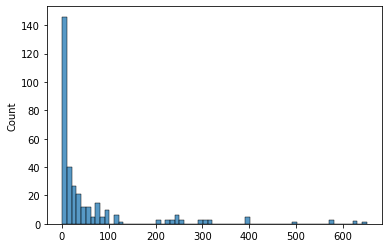

In [ ]:
vals, counts = np.unique(nn_lists_idx.ravel(), return_counts=True)
sns.histplot(counts, binwidth=10);

If a sample is returned as a nearest neighbor very often because it happens to be closer to the test points than other points, that would be OK. But in this case, that's not what is going on.

We are using `argsort` to get the K smallest distances to each test point. However, if there are more than K training samples that are at the minimum distance for a particular test point (i.e. a tie of more than K values, all having the minimum distance), `argsort` will return the first K of those in order of their index in the distance matrix (their order in `idx_tr`). 

This means that some training samples will be returned much more often than others, simply because of their index.

To fix this, we will use an alternative, `lexsort`, that sorts first by the second argument, then by the first argument; and we will pass a random array as the first argument:

In [ ]:
k = 3
r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

Now, we don't see nearly as much repitition of individual training samples among the nearest neighbors:

In [ ]:
print(nn_lists_idx[0:50])

[[ 3897 21848  3691]
 [18869  2750 18598]
 [ 7810 20179 16903]
 [19648 13579  9845]
 [ 5029 19615 22019]
 [ 3001  8147 16062]
 [19925  9381  9024]
 [12432 14909  7302]
 [ 4934 11373 20065]
 [ 9112   623  5325]
 [21941 17268 15759]
 [14540  8185  8172]
 [19573 12298 15269]
 [ 3222  8065  2276]
 [20615  1359 21959]
 [ 1889 18250   199]
 [16693 16232 20264]
 [12981 21437  9287]
 [ 6336 14061 16039]
 [12671 18241 18667]
 [12724  5671 22173]
 [ 2073 19523 15317]
 [20946  9675  7103]
 [  464   952 11847]
 [19176  4148 14288]
 [ 4236  5338 16761]
 [17793 14091 14594]
 [ 3707 18149 15114]
 [ 1527  5295  1058]
 [ 5582 21337  3552]
 [ 1631 22081  9989]
 [ 8549 22742  5088]
 [ 9484  9889 10845]
 [22050  7027 11753]
 [ 4759  3110 11305]
 [ 9474 16983 21622]
 [19698  2180 12000]
 [11714  9615  4004]
 [17881  2084 18216]
 [19813 16308 22009]
 [ 5005 12601 10202]
 [14675 12844  9355]
 [16414 19885 22281]
 [ 1301 18122 17839]
 [ 6013 20801 11285]
 [ 2360  3072 16715]
 [16798  5481  5917]
 [13612  6130

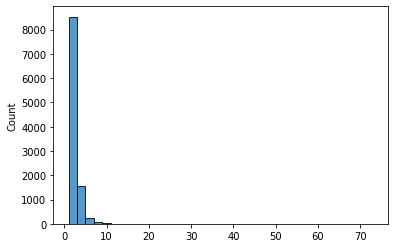

In [ ]:
vals, counts = np.unique(nn_lists_idx.ravel(), return_counts=True)
sns.histplot(counts, binwidth=2);

Let's get the accuracy of this solution:

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.6046783625730994

Depending on the train-test split, the new classifier may have better performance (as it did in this case), or similar performance to the first classifier.

But conceptually, it is more sound, and less "fragile" - less sensitive to the draw of training data.

### Using K-fold CV to select the number of neighbors

As a next step, to improve the classifier performance, we can use K-fold CV to select the number of neighbors. Note that we do not have to re-compute the distances inside each iteration of the loop, we can use pre-computed distances, so this is much faster than you might expect!

In [ ]:
# pre-compute a distance matrix of training vs. training data
distances_kfold = np.zeros(shape=(len(idx_tr), len(idx_tr)))

for idx in tqdm(range(len(idx_tr)),  total=len(idx_tr), desc="Distance matrix"):
  distances_kfold[idx] = custom_distance(X.iloc[idx_tr[idx]], X.iloc[idx_tr])

Distance matrix: 100%|██████████| 15958/15958 [00:37<00:00, 429.09it/s]


In [ ]:
from sklearn.model_selection import KFold

n_fold = 5
k_list = np.arange(1, 301, 10)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

kf = KFold(n_splits=5)

print(kf)

for isplit, idx_k in enumerate(kf.split(idx_tr)):

  print("Iteration %d" % isplit)

  # Outer loop: select training vs. validation data (out of training data!)
  idx_tr_k, idx_val_k = idx_k 

  # get target variable values for validation data
  y_val_kfold = y.iloc[idx_tr[idx_val_k]]

  # get distance matrix for validation set vs. training set
  distances_val_kfold   = distances_kfold[idx_val_k[:, None], idx_tr_k]

  # generate a random matrix for tie breaking
  r_matrix = np.random.random(size=(distances_val_kfold.shape))

  # loop over the rows of the distance matrix and the random matrix together with zip
  # for each pair of rows, return sorted indices from distances_val_kfold
  distances_sorted = np.array([np.lexsort((r, row)) for r, row in zip(r_matrix,distances_val_kfold)])

  # Inner loop: select value of K, number of neighbors
  for idx_k, k in enumerate(k_list):

    # now we select the indices of the K smallest, for different values of K
    # the indices in  distances_sorted are with respect to distances_val_kfold
    # from those - get indices in idx_tr_k, then in X
    nn_lists_idx = idx_tr[idx_tr_k[distances_sorted[:,:k]]]

    # get validation accuracy for this value of k
    y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
    acc_list[idx_k, isplit] = accuracy_score(y_val_kfold, y_pred)

KFold(n_splits=5, random_state=None, shuffle=False)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


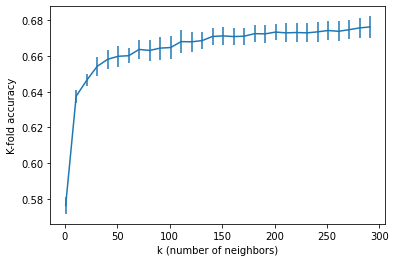

In [ ]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

Using this, we can find a better choice for K.

In [ ]:
best_k = k_list[np.argmax(acc_list.mean(axis=1))]
print(best_k)

291


And compute the accuracy of the overall classifier on the test data, using this K.

In [ ]:
r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:best_k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.6809941520467836

## Improve on the basic classifier

In the sections above, I showed you how to use a K nearest neighbors classifier to predict the vote of a test sample based on three features: race,  education, and age.

For this assignment, you will try to improve the performance of your classifier in three ways:

* by adding more features
* by improving the distance metric
* by using feature selection or feature weights

You can be creative in selecting your approach to each of these three - there isn't one right answer! But, you'll have to explain and justify your decisions.


### Use more features

First, you will improve the model by additional features that you think may be relevant. 

But, do *not* use questions that directly ask the participants how they feel about individual candidates, or about their party affiliation or political leaning.

Your choices for additional features include:

* More demographic information: `INCOME16GEN`, `MARRIED`, `RELIGN10`, `ATTEND16`, `LGBT`, `VETVOTER`
* Opinions about political issues and about what factors are most important in determining which candidate to vote for: `TRACK`, `SUPREME16`,  `FINSIT`, `IMMWALL`, `ISIS16`, `LIFE`, `TRADE16`, `HEALTHCARE16`, `GOVTDO10`, `GOVTANGR16`, `QLT16`, `ISSUE16`, `NEC`

Refer to the PDF documentation to see the question and the possible answers corresponding to each of these features.  You may also choose to do some exploratory data analysis, to help you understand these features better.



For your convenience, here are all the possible answers to those survey questions:

In [ ]:
features = ['INCOME16GEN', 'MARRIED', 'RELIGN10', 'ATTEND16', 'LGBT', 'VETVOTER', 
            'TRACK', 'SUPREME16',  'FINSIT', 'IMMWALL', 'ISIS16', 'LIFE', 
            'TRADE16', 'HEALTHCARE16', 'GOVTDO10', 'GOVTANGR16', 'QLT16', 
            'ISSUE16', 'NEC']

for f in features:
  print(f)
  print(df[f].value_counts())
  print("***************************************************")

INCOME16GEN
$50,000-$99,999      2606
$100,000-$199,999    2015
$30,000-$49,999      1586
Under $30,000        1385
$250,000 or more      495
$200.000-$249,999     350
Name: INCOME16GEN, dtype: int64
***************************************************
MARRIED
Yes    5182
No     3611
Name: MARRIED, dtype: int64
***************************************************
RELIGN10
Other christian    1996
Catholic           1792
Protestant         1784
None               1137
Other               577
Jewish              196
Mormon              114
Muslim               71
Name: RELIGN10, dtype: int64
***************************************************
ATTEND16
Once a week or more    1411
A few times a year     1206
Never                   916
A few times a month     697
Name: ATTEND16, dtype: int64
***************************************************
LGBT
No     4007
Yes     194
Name: LGBT, dtype: int64
***************************************************
VETVOTER
No     3673
Yes     562
Name: VETVOTE

It is up to you to decide which features to include in your model. However, you must include

* at least four features that are encoded using an ordinal encoder (and you should include an explicit mapping for these), and 
* at least four features that are encoded using one-hot encoding.

(If you decide to use the features I used above, they do "count" as part of the four. For example, you can use age, education, and two additional ordinal-encoded features, and race and three other one-hot-encoded features.)

#### To Do 1: Encode ordinal features

In the following cells, prepare your ordinal-encoded features as demonstrated in the "Encode ordinal features" section earlier in this notebook. 

Use at least four features that are encoded using an ordinal encoder. (You can choose which features to include, but they should be features for which the values have a logical ordering that should be preserved in the distance computations!)

Make sure to explicitly specify the mappings for these, so that you can be sure that they are encoded using the correct logical order, and use other "best practices" described in that section where applicable.

Save the ordinal-encoded columnns in a data frame called `df_enc_ord`.

In [ ]:
# TODO 1 - Encode at least four ordinal features

In [ ]:
# - these variables can *only* be ordinal-encoded, and shouldn't be OH-encoded.
#    using OH-encoding would lose important relative distance information.
# - Omit answers can't be mapped to the same ordinal scale (should Omit be closer
#    to "Angry" or "Enthusiastic", for example? there is no justifiable answer)
#    so we map them to -1 and then to NaN
# - within each "range" the encoding should follow the logical order from
#    high to low or low to high. 
# - the encoded columns should be scaled to the 0-1 range afterwards. Otherwise,
#    a feature will be weighted more heavily just because it has more categories.
mapping_dict = {'col': 'AGE', 'mapping': 
                {'18-29': 1, 
                 '30-44': 2,
                 '45-65': 3,
                 '65+': 4}
                }, {'col': 'EDUC12R', 'mapping':  
                  {'High school or less': 1,
                   'Some college/assoc. degree': 2,
                   'College graduate': 3,
                   'Postgraduate study': 4}
                    }, {'col': 'INCOME16GEN', 'mapping':  
                  {'Under $30,000': 1,
                   '$30,000-$49,999': 2,
                   '$50,000-$99,999': 3,
                   '$100,000-$199,999': 4,
                   '$200.000-$249,999': 5,
                   '$250,000 or more': 6}                  
                    }, {'col': 'GOVTANGR16', 'mapping':  
                  {'Angry': 1,
                   'Dissatisfied, but not angry': 2,
                   'Satisfied, but not enthusiastic': 3,
                   'Enthusiastic': 4,
                   'Omit': -1}
                    }, {'col': 'ATTEND16', 'mapping':  
                  {'Never': 1,
                   'A few times a year': 2,
                   'A few times a month': 3,
                   'Once a week or more': 4}
                    }, {'col': 'SUPREME16', 'mapping':  
                  {'Not a factor at all': 1,
                   'A minor factor': 2,
                   'An important factor': 3,
                   'The most important factor': 4,
                   'Omit': -1}
                    }, {'col': 'ISIS16', 'mapping':  
                  {'Very badly': 1,
                   'Somewhat badly': 2,
                   'Somewhat well': 3,
                   'Very well': 4,
                   'Omit': -1}
                    }, {'col': 'LIFE', 'mapping':  
                  {'Worse than life today': 1,
                   'About the same': 2,
                   'Better than life today': 3,
                   'Omit': -1}
                    }, {'col': 'NEC', 'mapping':  
                  {'Excellent': 1,
                   'Good': 2,
                   'Not so good': 3,
                   'Poor': 4,
                   'Omit': -1}
                    }, {'col': 'HEALTHCARE16', 'mapping':  
                  {'Went too far': 1,
                   'Was about right': 2,
                   'Did not go far enough': 3,
                   'Omit': -1}
                    }, {'col': 'FINSIT', 'mapping':  
                  {'Worse today': 1,
                   'About the same': 2,
                   'Better today': 3,
                   'Omit': -1}
                    }, {'col': 'TRADE16', 'mapping':  
                  {'Takes away U.S. jobs': 1,
                   'Has no effect on U.S. jobs': 2,
                   'Creates more U.S. jobs': 3,
                   'Omit': -1}
                    }
features_ord = ['EDUC12R', 'AGE', 'INCOME16GEN', 'ATTEND16', 'SUPREME16', 'ISIS16', 'LIFE', 'GOVTANGR16', 'NEC', 'HEALTHCARE16', 'FINSIT', 'TRADE16']
enc_ord = ce.OrdinalEncoder(handle_missing='return_nan', mapping=mapping_dict)
enc_ord.fit(df[features_ord])
df_enc_ord = enc_ord.transform(df[features_ord])

df_enc_ord.replace(-1, float("NaN"), inplace=True)

for col in df_enc_ord.columns:
  df_enc_ord[col] = df_enc_ord[col]-df_enc_ord[col].min(skipna=True)
  df_enc_ord[col] = df_enc_ord[col]/df_enc_ord[col].max(skipna=True)


Once you are finished processing the ordinal-encoded columns, print the names of the columns, and use `describe` to check the count of each column. Make sure that the range of each column is 0-1. Also make sure that missing values and "Omit" values are recorded as NaN.

In [ ]:
df_enc_ord.columns

Index(['EDUC12R', 'AGE', 'INCOME16GEN', 'ATTEND16', 'SUPREME16', 'ISIS16',
       'LIFE', 'GOVTANGR16', 'NEC', 'HEALTHCARE16', 'FINSIT', 'TRADE16'],
      dtype='object')

In [ ]:
df_enc_ord.describe(include='all')

,EDUC12R,AGE,INCOME16GEN,ATTEND16,SUPREME16,ISIS16,LIFE,GOVTANGR16,NEC,HEALTHCARE16,FINSIT,TRADE16
count,21798.000000,22640.000000,8437.000000,4230.000000,4338.000000,4170.000000,4360.000000,4553.000000,4448.000000,4240.000000,4307.000000,4228.000000
mean,0.502202,0.542609,0.396302,0.538455,0.601352,0.424620,0.552867,0.394392,0.593825,0.429953,0.530532,0.485691
std,0.329376,0.323963,0.266629,0.385464,0.313631,0.305561,0.426003,0.284469,0.265140,0.442013,0.386649,0.471166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.333333,0.200000,0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000
50%,0.333333,0.666667,0.400000,0.333333,0.666667,0.333333,0.500000,0.333333,0.666667,0.500000,0.500000,0.500000
75%,0.666667,0.666667,0.600000,1.000000,0.666667,0.666667,1.000000,0.666667,0.666667,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### To Do 2: Encode categorical features



In the following cells, prepare the features that should be one-hot encoded, as demonstrated in the "Encode categorical features" section earlier in this notebook.  Make sure to use any "best practices" described in that section where applicable.

Use at least four features that are encoded using a one-hot encoder. (You can choose which features to include, but they should be features for which the values have *no* logical ordering.)

Save the ordinal-encoded columnns in `df_enc_oh`.

In [ ]:
# TODO 2 - encode at least four one-hot-encoded features

In [ ]:
features_oh =  ['RACE', 'ISSUE16', 'QLT16', 'RELIGN10',                               # these variables can *only* be OH-encoded, not ordinal-encoded
                'SEX', 'MARRIED', 'LGBT', 'TRACK', 'VETVOTER', 'IMMWALL', 'GOVTDO10'] # these binary variables could be encoded either way
enc_oh = ce.OneHotEncoder(use_cat_names=True, handle_missing= 'return_nan')
enc_oh.fit(df[features_oh])
df_enc_oh = enc_oh.transform(df[features_oh])
# we drop the Omit and NaN indicator columns
df_enc_oh.drop(['RACE_nan', 'ISSUE16_nan', 'ISSUE16_Omit', 'QLT16_Omit', 
               'QLT16_nan', 'RELIGN10_nan',
                'SEX_nan', 'MARRIED_nan', 'LGBT_nan', 'TRACK_nan', 'TRACK_Omit',
               'VETVOTER_nan', 'IMMWALL_nan', 'IMMWALL_Omit', 'GOVTDO10_nan', 'GOVTDO10_Omit'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Print the columns of your one-hot encoded features. Make sure you have dropped the columns corresponding with NaN and "Omit" in the title, which should not be included in the distance computations. (You should already represent NaNs directly in the data.)

In [ ]:
df_enc_oh.columns

Index(['RACE_Hispanic/Latino', 'RACE_Asian', 'RACE_Other', 'RACE_Black',
       'RACE_White', 'ISSUE16_Foreign policy', 'ISSUE16_The economy',
       'ISSUE16_Terrorism', 'ISSUE16_Immigration', 'QLT16_Has good judgment',
       'QLT16_Can bring needed change', 'QLT16_Has the right experience',
       'QLT16_Cares about people like me', 'RELIGN10_Protestant',
       'RELIGN10_None', 'RELIGN10_Other christian', 'RELIGN10_Catholic',
       'RELIGN10_Jewish', 'RELIGN10_Other', 'RELIGN10_Muslim',
       'RELIGN10_Mormon', 'SEX_Female', 'SEX_Male', 'MARRIED_Yes',
       'MARRIED_No', 'LGBT_No', 'LGBT_Yes',
       'TRACK_Seriously off on the wrong track',
       'TRACK_Generally going in the right direction', 'VETVOTER_No',
       'VETVOTER_Yes', 'IMMWALL_Oppose', 'IMMWALL_Support',
       'GOVTDO10_Government should do more to solve problems',
       'GOVTDO10_Government is doing too many things better left to businesses and individuals'],
      dtype='object')

In [ ]:
df_enc_oh.describe(include='all')

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,QLT16_Has good judgment,QLT16_Can bring needed change,QLT16_Has the right experience,QLT16_Cares about people like me,RELIGN10_Protestant,RELIGN10_None,RELIGN10_Other christian,RELIGN10_Catholic,RELIGN10_Jewish,RELIGN10_Other,RELIGN10_Muslim,RELIGN10_Mormon,SEX_Female,SEX_Male,MARRIED_Yes,MARRIED_No,LGBT_No,LGBT_Yes,TRACK_Seriously off on the wrong track,TRACK_Generally going in the right direction,VETVOTER_No,VETVOTER_Yes,IMMWALL_Oppose,IMMWALL_Support,GOVTDO10_Government should do more to solve problems,GOVTDO10_Government is doing too many things better left to businesses and individuals
count,22488.000000,22488.000000,22488.000000,22488.000000,22488.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,22749.000000,22749.000000,8793.000000,8793.000000,4201.000000,4201.000000,4319.000000,4319.000000,4235.000000,4235.000000,4365.000000,4365.000000,4429.000000,4429.000000
mean,0.098275,0.030505,0.030283,0.133093,0.707844,0.123596,0.537546,0.183224,0.116921,0.189899,0.407164,0.225609,0.145066,0.232686,0.148298,0.260337,0.233729,0.025564,0.075258,0.009260,0.014869,0.554750,0.445250,0.589332,0.410668,0.953821,0.046179,0.605233,0.358648,0.867296,0.132704,0.549828,0.408935,0.470084,0.480018
std,0.297692,0.171976,0.171368,0.339683,0.454764,0.329138,0.498616,0.386872,0.321344,0.392243,0.491333,0.418006,0.352187,0.422571,0.355418,0.438847,0.423229,0.157841,0.263824,0.095791,0.121036,0.497004,0.497004,0.491983,0.491983,0.209899,0.209899,0.488857,0.479659,0.339294,0.339294,0.497568,0.491694,0.499161,0.499657
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Create a combined data matrix

In [ ]:
X = pd.concat([df_enc_oh, df_enc_ord], axis=1)

In [ ]:
X.describe(include='all')

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,QLT16_Has good judgment,QLT16_Can bring needed change,QLT16_Has the right experience,QLT16_Cares about people like me,RELIGN10_Protestant,RELIGN10_None,RELIGN10_Other christian,RELIGN10_Catholic,RELIGN10_Jewish,RELIGN10_Other,RELIGN10_Muslim,RELIGN10_Mormon,SEX_Female,SEX_Male,MARRIED_Yes,MARRIED_No,LGBT_No,LGBT_Yes,TRACK_Seriously off on the wrong track,TRACK_Generally going in the right direction,VETVOTER_No,VETVOTER_Yes,IMMWALL_Oppose,IMMWALL_Support,GOVTDO10_Government should do more to solve problems,GOVTDO10_Government is doing too many things better left to businesses and individuals,EDUC12R,AGE,INCOME16GEN,ATTEND16,SUPREME16,ISIS16,LIFE,GOVTANGR16,NEC,HEALTHCARE16,FINSIT,TRADE16
count,22488.000000,22488.000000,22488.000000,22488.000000,22488.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,22749.000000,22749.000000,8793.000000,8793.000000,4201.000000,4201.000000,4319.000000,4319.000000,4235.000000,4235.000000,4365.000000,4365.000000,4429.000000,4429.000000,21798.000000,22640.000000,8437.000000,4230.000000,4338.000000,4170.000000,4360.000000,4553.000000,4448.000000,4240.000000,4307.000000,4228.000000
mean,0.098275,0.030505,0.030283,0.133093,0.707844,0.123596,0.537546,0.183224,0.116921,0.189899,0.407164,0.225609,0.145066,0.232686,0.148298,0.260337,0.233729,0.025564,0.075258,0.009260,0.014869,0.554750,0.445250,0.589332,0.410668,0.953821,0.046179,0.605233,0.358648,0.867296,0.132704,0.549828,0.408935,0.470084,0.480018,0.502202,0.542609,0.396302,0.538455,0.601352,0.424620,0.552867,0.394392,0.593825,0.429953,0.530532,0.485691
std,0.297692,0.171976,0.171368,0.339683,0.454764,0.329138,0.498616,0.386872,0.321344,0.392243,0.491333,0.418006,0.352187,0.422571,0.355418,0.438847,0.423229,0.157841,0.263824,0.095791,0.121036,0.497004,0.497004,0.491983,0.491983,0.209899,0.209899,0.488857,0.479659,0.339294,0.339294,0.497568,0.491694,0.499161,0.499657,0.329376,0.323963,0.266629,0.385464,0.313631,0.305561,0.426003,0.284469,0.265140,0.442013,0.386649,0.471166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.200000,0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.333333,0.666667,0.400000,0.333333,0.666667,0.333333,0.500000,0.333333,0.666667,0.500000,0.500000,0.500000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.666667,0.666667,0.600000,1.000000,0.666667,0.666667,1.000000,0.666667,0.666667,1.000000,1.000000,1.000000
max,1.000000,1.

#### To Do 3: Describe your choice of features


In a text cell, explain the features you have chosen to add to the model. 

* Why did you select this particular set of features? 
* Do you have reason to believe these specific features will be predictive of 2016 presidential vote? Explain.
* Do you think these features will give you good "coverage" across the respondents? (For example, do you have at least one feature from each version of the survey?)

---

In this solution, I will do feature selection or weighting so that irrelevant features will be weighted less. Therefore, I include all of the features as a starting point.

For reference, here's the model performance on my new, expanded set of features:

(Note that I am looking at the test performance after I finish designing and executing model, just to get an idea of the impact of each change I made to the model. I am *not* changing my design based on the test set performance - that would not be allowed!)

In [ ]:
# pre-compute a distance matrix of training vs. training data
distances_kfold = np.zeros(shape=(len(idx_tr), len(idx_tr)))

for idx in tqdm(range(len(idx_tr)),  total=len(idx_tr), desc="Distance matrix"):
  distances_kfold[idx] = custom_distance(X.iloc[idx_tr[idx]], X.iloc[idx_tr])

Distance matrix: 100%|██████████| 15958/15958 [03:55<00:00, 67.77it/s]


In [ ]:
from sklearn.model_selection import KFold

n_fold = 5
k_list = np.arange(1, 301, 10)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

kf = KFold(n_splits=5)

print(kf)

for isplit, idx_k in enumerate(kf.split(idx_tr)):

  print("Iteration %d" % isplit)

  # Outer loop: select training vs. validation data (out of training data!)
  idx_tr_k, idx_val_k = idx_k 

  # get target variable values for validation data
  y_val_kfold = y.iloc[idx_tr[idx_val_k]]

  # get distance matrix for validation set vs. training set
  distances_val_kfold   = distances_kfold[idx_val_k[:, None], idx_tr_k]

  # generate a random matrix for tie breaking
  r_matrix = np.random.random(size=(distances_val_kfold.shape))

  # loop over the rows of the distance matrix and the random matrix together with zip
  # for each pair of rows, return sorted indices from distances_val_kfold
  distances_sorted = np.array([np.lexsort((r, row)) for r, row in zip(r_matrix,distances_val_kfold)])

  # Inner loop: select value of K, number of neighbors
  for idx_k, k in enumerate(k_list):

    # now we select the indices of the K smallest, for different values of K
    # the indices in  distances_sorted are with respect to distances_val_kfold
    # from those - get indices in idx_tr_k, then in X
    nn_lists_idx = idx_tr[idx_tr_k[distances_sorted[:,:k]]]

    # get validation accuracy for this value of k
    y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
    acc_list[idx_k, isplit] = accuracy_score(y_val_kfold, y_pred)

KFold(n_splits=5, random_state=None, shuffle=False)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


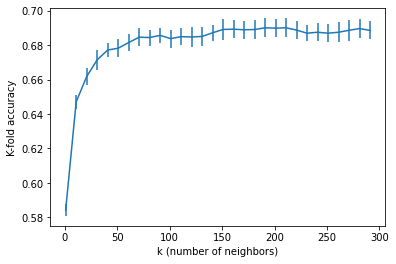

In [ ]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

In [ ]:
best_k = k_list[np.argmax(acc_list.mean(axis=1))]
print(best_k)

191


In [ ]:
distances_custom = np.zeros(shape=(len(idx_ts), len(idx_tr)))
for idx in tqdm(range(len(idx_ts)),  total=len(idx_ts), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X.iloc[idx_ts[idx]], X.iloc[idx_tr])

Distance matrix: 100%|██████████| 6840/6840 [01:38<00:00, 69.42it/s]


In [ ]:
r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:best_k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.6864035087719298

In this case, my test accuracy is about the same as before. 

In general, it's not unusual for KNN performance to get worse when I add more features, especially if many of them will not be relevant! This will be addressed when we do feature selection or feature weighting, to prioritize the most important and useful features.

### Design a custom distance metric

Next, you should improve on the basic distance metric we used above. You can design any distance metric you think is appropriate (there is no one right answer to this question)!, but it must meet these criteria:

* it should handle NaN values in a reasonable way. Remember that a NaN does not mean two samples are *different* with respect to a feature; it means you don't have any information about whether they agree or disagree.
* samples should be considered closer if they have more features in common (assuming the same number of features that disagree).
* **optional**: you may decide that in some cases, samples with many features in common but a few small disagreements, should be considered closer than samples with few features in common but no disagreements.


![](https://raw.githubusercontent.com/ffund/ml-notebooks/master/notebooks/images/exit-poll-nan-distance.png)

For example, consider the image above, with a test sample (with bold outline) and three training samples. Red squares indicate missing values.

Training sample $x_1$ and training sample $x_2$ both have no disagreements with the test sample $x_t$. According to our basic L1 distance metric, they should both have 0 distance. However, in your modified metric, training sample $x_2$ should be considered closer to the test sample $x_t$, because it has more features in common.

Training sample $x_3$ has many features in common with the test sample $x_t$, but also one disagreement. You can decide which should be considered a closer neighbor of $x_t$: $x_1$ or $x_3$. But, you should explain your choice and justify your decision in the explanation.

#### To Do 4: Implement a custom distance metric

In [ ]:
# TODO 4 - implement distance metric


In [ ]:
def custom_distance(a, b):
  dif = np.abs(np.subtract(a,b))    # element-wise absolute difference
  # dif will have NaN for each element where either a or b is NaN
  l1 = np.nansum(dif, axis=1)  # sum of differences, treating NaN as 0
  n_non_nan = np.sum(~np.isnan(dif), axis=1)
  n_non_nan = np.clip(n_non_nan, 0.001, len(a)) # avoid division by zero
  return (l1+1.0)/n_non_nan - 1.0/len(a)


#### To Do 5: Describe your distance metric and justify your design choices

Describe your distance metric. First, write down an exact expression for 

$$d(a, b) $$

Explain *why* you chose this function, and how it satisfies the criteria above.

Use several *specific examples* from the data to show how your distance function produces more meaningful distances than the previous "naive" distance metric. Compare and contrast the previous "naive" distance metric and your new distance metric on these examples.

--- 

In my implementation, I:

* use an L1 distance computed over the features that are non-NaN *for both samples*, 
* normalize it by the number of features used in the distance computation, and 
* also add a penalty term that is large when the number of features used in the distance computation (features that are non-NaN *for both samples*) is small. This will increase the distance between pairs of samples that have very little in common but also very little that they disagree on.
* I subtract $\frac{1}{N}$ just so that the pairwise distance will be zero for identical samples with no NaNs.

 
 
$$d(a,b) = \frac{\lVert a - b \rVert_{\ell_{1}}}{N_{\text{non-NaN}}} + \frac{1}{N_{\text{non-NaN}}}  - \frac{1}{N}$$
 
where $N_{\text{non-NaN}}$ is the number of elements for which both $a$ and $b$ have non-NaN values.  I set a lower bound on this to avoid division by zero, though.

The advantages of this distance function are:

* the distance increases when there are more disagreements between the vectors
* the degree of "disagreement", L1 distance, works for OH-encoded and ordinal-encoded values. (If I used strict equality/inequality instead, I would loss some of the information encoded using ordinal-encoding.)
* given a fixed number of disagreements between the vectors, the distance decreases when there are more points of agreement (because of the $\frac{1}{N_{\text{non-NaN}}}$ term)

Here are some "toy" examples. For this distance metric,

* ✅ $d(a_0, b_1) > d(a_0, b_2) $ (B1 and B2 have the same number of NaNs, but B1 has 1 disagreement with A0 and B2 has 0 disagreements. So B1's distance should be greater.)
* ✅ $d(a_0, b_1) > d(a_0, b_0) $ (Both B1 and B0 have one sample that is different from A0, but in B1 the magnitude of the different is greater. So B1's distance should be greater.)
* ✅ $d(a_0, b_3) > d(a_0, b_2) $ (Both B2 and B3 not disagreements with A0, but B2 has more in common with A0. So B3's distance should be greater.)
* ✅ $d(a_0, b_4) > d(a_0, b_2) $ (Both B2 and B4 have two NaNs, and both have 0 disagreements with A0. But the combination of A0, B4 has more NaNs than the combination of A0, B2, so B4's distance should be greater.)
* ✅ $d(a_1, b_0) = 0$ (We know that these samples are identical - all feature values are known, and all are the same -  so their distance should be 0.)
* ✅ $d(a_0, b_5)$ and $d(a_1, b_5$ are large. (When two samples have no non-NaN features in common, we shouldn't consider them neighbors because we don't know of anything they have in common! For my distance function, the denominator of the distance function will be zero in this case. I "clipped" it to a small value > 0 instead to avoid division by zero, and make the distance large.)

In [ ]:
a = np.array([[0, 1, np.nan, 1, 0, 0.3],    # A0
              [0, 1, 1,      1, 0, 0.5]] )  # A1
b = np.array([[0, 1, 1,      1, 0, 0.5],              # B0
              [0, 0, np.nan, 1, 0, np.nan],           # B1
              [0, 1, np.nan, 1, 0, np.nan],           # B2
              [0, 1, np.nan, np.nan, np.nan, np.nan], # B3
              [0, np.nan, 1, 1, 0, np.nan],           # B4
              [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]    # B5
     ])
distances_ex = np.zeros(shape=(len(a), len(b)))
for idx in range(len(a)):
  distances_ex[idx] = custom_distance(a[idx], b)

np.set_printoptions(suppress=True)
print(distances_ex)

[[  0.07   0.33   0.08   0.33   0.17 999.83]
 [  0.     0.33   0.08   0.33   0.08 999.83]]


Other alternative approaches include:

* use a measure of disagreement (L1 distance, L2 distance) with a "penalty" that increases with the number of columns that are NaN in one or both samples.
* use a measure that decreases with more "agreement" between samples, and with a negative "penalty" on the number of columns that are NaN in one or both samples.
* use a measure that adds a measure of disagreement (L1 or L2 distance) and subtracts a measure of agreement.
* use a ratio where:
 * the numerator has some combination of: number of NaN fields, L1 or L2 distance or other measure of disagreement
 * the denominator has some combination of: number of non-NaN fields, measure of agreement


For reference, here's the performance of my model with the new custom distance metric. 

(Note that I am looking at the test performance after I finish designing and executing model, just to get an idea of the impact of each change I made to the model. I am *not* changing my design based on the test set performance - that would not be allowed!)

In [ ]:
# pre-compute a distance matrix of training vs. training data
distances_kfold = np.zeros(shape=(len(idx_tr), len(idx_tr)))

for idx in tqdm(range(len(idx_tr)),  total=len(idx_tr), desc="Distance matrix"):
  distances_kfold[idx] = custom_distance(X.iloc[idx_tr[idx]], X.iloc[idx_tr])

Distance matrix: 100%|██████████| 15958/15958 [05:43<00:00, 46.46it/s]


In [ ]:
from sklearn.model_selection import KFold

n_fold = 5
k_list = np.arange(1, 301, 10)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

kf = KFold(n_splits=5)

print(kf)

for isplit, idx_k in enumerate(kf.split(idx_tr)):

  print("Iteration %d" % isplit)

  # Outer loop: select training vs. validation data (out of training data!)
  idx_tr_k, idx_val_k = idx_k 

  # get target variable values for validation data
  y_val_kfold = y.iloc[idx_tr[idx_val_k]]

  # get distance matrix for validation set vs. training set
  distances_val_kfold   = distances_kfold[idx_val_k[:, None], idx_tr_k]

  # generate a random matrix for tie breaking
  r_matrix = np.random.random(size=(distances_val_kfold.shape))

  # loop over the rows of the distance matrix and the random matrix together with zip
  # for each pair of rows, return sorted indices from distances_val_kfold
  distances_sorted = np.array([np.lexsort((r, row)) for r, row in zip(r_matrix,distances_val_kfold)])

  # Inner loop: select value of K, number of neighbors
  for idx_k, k in enumerate(k_list):

    # now we select the indices of the K smallest, for different values of K
    # the indices in  distances_sorted are with respect to distances_val_kfold
    # from those - get indices in idx_tr_k, then in X
    nn_lists_idx = idx_tr[idx_tr_k[distances_sorted[:,:k]]]

    # get validation accuracy for this value of k
    y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
    acc_list[idx_k, isplit] = accuracy_score(y_val_kfold, y_pred)

KFold(n_splits=5, random_state=None, shuffle=False)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


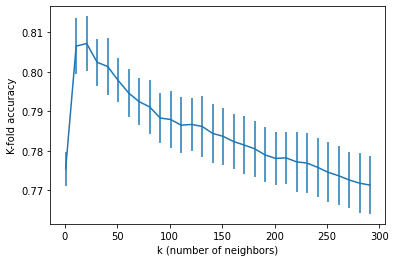

In [ ]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

In [ ]:
best_k = k_list[np.argmax(acc_list.mean(axis=1))]
print(best_k)

21


In [ ]:
distances_custom = np.zeros(shape=(len(idx_ts), len(idx_tr)))
for idx in tqdm(range(len(idx_ts)),  total=len(idx_ts), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X.iloc[idx_ts[idx]], X.iloc[idx_tr])

Distance matrix: 100%|██████████| 6840/6840 [02:24<00:00, 47.42it/s]


In [ ]:
r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:best_k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.8021929824561403

P.S. intuitively, does it make sense that after improving the distance metric, the optimal $K$ decreases? Why?


### Use feature selection or feature weights for better performance

Because the K nearest neighbor classifier weights each feature equally in the distance metric, including features that are not relevant for predicting the target variable can actually make performance worse.

To improve performance, you could either:

* use a subset of features that are most important, or
* use feature weights, so that more important features are scaled up and less important features are scaled down.

Feature selection has another added benefit - if you use fewer features, than you also get a faster inference time.

There are a few general approaches to feature selection:

* **Wrapper methods** use the ML model on the data, and  select relevant features based the model performance. (For example, we might train a linear regression on different combinations of features, and then select the one that has the best performance on a validation set.)
* **Filter methods** use statistical characteristics of the data to select the features that are more useful for predicting the target variable. (For example, we might select the features that have the highest correlation with the target variable.)
* **Embedded methods** do feature selection "automatically" as part of the model training. (LASSO is an example of this type of feature selection.)

We also need to decide whether we want to take the dependencies between features into account, or not.

With **univariate feature selection**, we consider each feature independently. For example, we might score each feature according to its correlation with the target variable, then pick the features with the highest scores. 

The problem with univariate feature selection is that some features may carry redundant information. In that case, we don't gain much from having both features in our model, but both will have similar scores.

As an alternative to univariate feature selection, we might consider **greedy multivariate feature selection**, where we start with a small number of features and then add features one at a time:

* Let $S^{t-1}$ be the set of selected features at time ${t-1}$.
* Compute the score for all combinations of the current set of features + one more feature
* For the next time step $S^t$, add the feature that gave you the best score.
* Stop when you have added all features, or if adding another feature decreases the score.

Feature weighting does not have the benefit of faster inference time, but it does have the advantage of not throwing out useful information.

As with feature selection, there are both wrapper methods and filter methods, but filter methods tend to be much easier to compute.

There are many options for feature selection or feature weighting, and you can choose anything that seems reasonable to you - there isn't one right answer here! But, you will have to explain and justify your choice. For full credit, your design decisions should be well supported by the data.

#### To Do 6: Implement feature selection or feature weighting

In this section, I demonstrate three examples of feature selection/weighting for this problem:

1. using a wrapper method for sequential feature selection. We start with the entire set of features, then iteratively try all the models *one size smaller* and select the best one by validation performance. After this iterative process, we have the "best" model for each size, and we choose the best *size* by validation performance.

2. using a filter method for feature weighting, by "scoring" each feature according to some statistical measure of how relevant it is, then using that score as the feature weight. We then use *all* features in the model, but the weight affects the distance calculations so that features with a large weight "count" more.

3. using a filter method to rank features by some statistical measure of relevance, then using K-Fold CV to decide what *size* feature set to use (a feature set of size $d$ means we use the $d$ best features according to our statistical score ranking!)


Some comparisons:

* none of them are "optimal" in the global sense.
* 1 is the most expensive, followed by 3; 2 is not very expensive.
* Only 1 directly evaluates *this* model's performance for different feature sets.
* For 2, we need to decide what scoring statistic to use. 
* 2 (feature weighting) has the benefit of not "losing" any information; even if a feature is not the most relevant, it still may carry some signal that we don't want to lose. With feature selection, we drop some features (even if they have some informative signal) so that they don't "overpower" more important features. With feature weighting, we get to keep all of the features.
* 1 and 3 (feature selection) have the benefit of reducing the size of the feature set, which makes subsequent computations faster.

In [ ]:
# TODO 6 - use either feature selection or feature weighting. 
# save the result in X_trans. 
# For the rest of this notebook, you will use X_trans instead of X

#### Basic wrapper for greedy sequential feature selection

The wrapper method is very expensive, because we need to compute many distance matrices for many candidate models. Here's a brief overview of how it works:

Starting from the full set of features, we  evaluate all of the candidate models with one *less* feature, and save the best one. In the next iteration, we use this as the baseline model, and evaluate the set of candidate models with one less feature than this, etc. 

We continue this iterative approach until we have a candidate model for every number of features from (size of all columns) to 1, and then we select the one with the best performance. 

For example, if the complete data set had 5 features: X1, X2, X3, X4, X5:

1. We would first evaluate the performance of the 5 feature model - with X1, X2, X3, X4, X5 -  on a validation set.
2. Then, we evaluate the performance of each of these models on a validation set, and select the best of them as the "best model with 4 features"
  * X1, X2, X3, X4
  * X1, X2, X3, X5
  * X1, X2, X4, X5
  * X1, X3, X4, X5
  * X2, X3, X4, X5
  
  For this example, let's imagine that the model with X1, X3, X4, X5 had the best validation performance.
3. Next, we evaluate the performance of each model excluding one feature from X1, X3, X4, X5:
  * X1, X3, X4
  * X1, X3, X5
  * X1, X4, X5
  * X3, X4, X5
  
  Let's imagine that the model with X3, X4, X5 had the best validation performance of the three-feature models.
4. In the next iteration, we evaluate the performance of each model excluding one feature from X3, X4, X5:
  * X3, X4
  * X3, X5
  * X4, X5
  
  Let's imagine that the X3, X4 model was the best two-feature model.
5. In the final iteration, we evaluate these two models: 
  * X3
  * X4

  and let's say that X4 was better.

Finally, we compare the validation scores of all of the "best" models for each model order:

1. X1, X2, X3, X4, X5 was the five-feature model
2. X1, X3, X4, X5 was the best four-feature model
3. X3, X4, X5 was the best three-feature model
4. X3, X4 was the best two-feature model
5. X4 was the best one-feature model

and select the one with the best validation performance.

In the implementation that follows, I used a small subset of the data to demonstrate the approach. (As a result, the validation accuracy is low for every model order.) It would take a very long time to train this wrapper method for the entire dataset.

In [ ]:
# Example 1: basic wrapper method for greedy multivariate feature selection
# this would take a VERY long time, so I'm showing how to use a subset of columns 
# and a subset of data to demo the concept


# change these values if you want to use the entire data set (WARNING: takes a long time to train!)
demo_cols = len(X.columns) # use len(X.columns) for the "full" solution, use smaller number to train faster
demo_ts_samples = 200  # number of test samples for the demo
demo_tr_samples = 1000 # number of training samples for the demo

cols = X.columns[:demo_cols] # initial set of columns
fs_dict = {}     # dictionary in which to store results

# choose a K to use for feature selection decision
k_fs = best_k # I use the best K from the previous section

# divide training data into training, validation
# I'm not using K-fold CV because it would take too long!
i_tr_fs, i_val_fs = next(ShuffleSplit(n_splits = 1, test_size = demo_ts_samples, train_size=demo_tr_samples, random_state = 3).split(idx_tr))
idx_tr_fs = idx_tr[i_tr_fs]    # indices in X of training data
idx_val_fs = idx_tr[i_val_fs]  # indices in X of validation data

### Get validation score for entire feature set

# distance matrix with all features
distances_fs = np.zeros(shape=(len(idx_val_fs), len(idx_tr_fs)))
for idx in range(len(idx_val_fs)):
  distances_fs[idx] = custom_distance(X.iloc[idx_tr[idx]][cols], X.iloc[idx_tr_fs][cols])
  distances_fs[idx] = custom_distance(X.iloc[idx_val_fs[idx]][cols], X.iloc[idx_tr_fs][cols])

# nearest neighbors
r_matrix = np.random.random(size=(distances_fs.shape))
nn_lists = np.array([np.lexsort((r, row))[:k_fs] for r, row in zip(r_matrix,distances_fs)])
nn_lists_idx = idx_tr_fs[nn_lists] # indices of nn in training set

# validation score
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
val_score_sub = accuracy_score(y.iloc[idx_val_fs], y_pred)

# put cols, score in a dictionary
fs_dict[0] = {'cols': cols, 'ncols': len(cols), 'val_score': val_score_sub}

for idx_out in tqdm(range(demo_cols-1)):

  # in each "round" of the outer loop, we consider a subset of features of size
  # (size of entire feature set) - idx_out

  fs_dict_in = {}     # dictionary in which to store results for this "round"

  for idx_in, c_in in enumerate(cols):
    # use cols excluding c_in to train classifier
    cols_sub = np.delete(cols, idx_in)

    # use cols_sub to train classifier
    distances_fs = np.zeros(shape=(len(idx_val_fs), len(idx_tr_fs)))
    for idx in range(len(idx_val_fs)):
      distances_fs[idx] = custom_distance(X.iloc[idx_val_fs[idx]][cols_sub], X.iloc[idx_tr_fs][cols_sub])

    r_matrix = np.random.random(size=(distances_fs.shape))
    nn_lists = np.array([np.lexsort((r, row))[:k_fs] for r, row in zip(r_matrix,distances_fs)])
    nn_lists_idx = idx_tr_fs[nn_lists]

    # get validation score
    y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
    val_score_sub = accuracy_score(y.iloc[idx_val_fs], y_pred)

    # put cols, score in a dictionary
    fs_dict_in[idx_in] = {'cols': cols_sub, 'ncols': len(cols_sub), 'val_score': val_score_sub}

  # get best score from 'inner' dictionary
  idx_best_sub = np.argmax([d['val_score'] for i, d in enumerate(fs_dict_in.values())])

  # let cols = the set of columns from that dictionary entry
  cols_best_sub  = fs_dict_in[idx_best_sub]['cols']
  score_best_sub = fs_dict_in[idx_best_sub]['val_score']

  # put cols, score in outer dictionary fs_dict
  fs_dict[idx_out+1] = {'cols': cols_best_sub, 'ncols': len(cols_best_sub), 'val_score': score_best_sub}
  cols = cols_best_sub  

100%|██████████| 46/46 [17:15<00:00, 22.51s/it]


In [ ]:
fs_dict

{0: {'cols': Index(['RACE_Hispanic/Latino', 'RACE_Asian', 'RACE_Other', 'RACE_Black',
         'RACE_White', 'ISSUE16_Foreign policy', 'ISSUE16_The economy',
         'ISSUE16_Terrorism', 'ISSUE16_Immigration', 'QLT16_Has good judgment',
         'QLT16_Can bring needed change', 'QLT16_Has the right experience',
         'QLT16_Cares about people like me', 'RELIGN10_Protestant',
         'RELIGN10_None', 'RELIGN10_Other christian', 'RELIGN10_Catholic',
         'RELIGN10_Jewish', 'RELIGN10_Other', 'RELIGN10_Muslim',
         'RELIGN10_Mormon', 'SEX_Female', 'SEX_Male', 'MARRIED_Yes',
         'MARRIED_No', 'LGBT_No', 'LGBT_Yes',
         'TRACK_Seriously off on the wrong track',
         'TRACK_Generally going in the right direction', 'VETVOTER_No',
         'VETVOTER_Yes', 'IMMWALL_Oppose', 'IMMWALL_Support',
         'GOVTDO10_Government should do more to solve problems',
         'GOVTDO10_Government is doing too many things better left to businesses and individuals',
         'EDUC

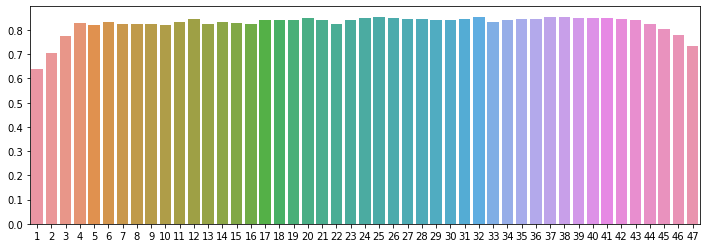

In [ ]:
fs_a = np.array([[fs_dict[d]['ncols'], fs_dict[d]['val_score']] for d in fs_dict])
plt.figure(figsize=(12,4)).gca();
sns.barplot(x=fs_a[:,0].astype('int'), y=fs_a[:,1]);

Note: scores are a bit lower because I'm not using the full dataset! KNN needs many samples to do well, especially when d is large.

In [ ]:
# get the entry with the highest validation score
idx_best_sub = np.argmax([d['val_score'] for i, d in enumerate(fs_dict.values())])
keep_cols = fs_dict[idx_best_sub]['cols']
fs_dict[idx_best_sub]

{'cols': Index(['RACE_Asian', 'RACE_Other', 'RACE_Black', 'RACE_White',
        'ISSUE16_Foreign policy', 'ISSUE16_The economy', 'ISSUE16_Terrorism',
        'ISSUE16_Immigration', 'QLT16_Has good judgment',
        'QLT16_Can bring needed change', 'QLT16_Cares about people like me',
        'RELIGN10_None', 'RELIGN10_Other christian', 'RELIGN10_Catholic',
        'RELIGN10_Jewish', 'RELIGN10_Other', 'RELIGN10_Muslim',
        'RELIGN10_Mormon', 'SEX_Female', 'MARRIED_Yes', 'MARRIED_No', 'LGBT_No',
        'LGBT_Yes', 'TRACK_Seriously off on the wrong track',
        'TRACK_Generally going in the right direction', 'VETVOTER_No',
        'VETVOTER_Yes', 'IMMWALL_Oppose', 'IMMWALL_Support',
        'GOVTDO10_Government should do more to solve problems',
        'GOVTDO10_Government is doing too many things better left to businesses and individuals',
        'AGE', 'ATTEND16', 'SUPREME16', 'ISIS16', 'LIFE', 'GOVTANGR16',
        'HEALTHCARE16'],
       dtype='object'), 'ncols': 38, 'val_s

In [ ]:
X_trans = X[keep_cols]
X_trans.describe()

,RACE_Asian,RACE_Other,RACE_Black,RACE_White,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,QLT16_Has good judgment,QLT16_Can bring needed change,QLT16_Cares about people like me,RELIGN10_None,RELIGN10_Other christian,RELIGN10_Catholic,RELIGN10_Jewish,RELIGN10_Other,RELIGN10_Muslim,RELIGN10_Mormon,SEX_Female,MARRIED_Yes,MARRIED_No,LGBT_No,LGBT_Yes,TRACK_Seriously off on the wrong track,TRACK_Generally going in the right direction,VETVOTER_No,VETVOTER_Yes,IMMWALL_Oppose,IMMWALL_Support,GOVTDO10_Government should do more to solve problems,GOVTDO10_Government is doing too many things better left to businesses and individuals,AGE,ATTEND16,SUPREME16,ISIS16,LIFE,GOVTANGR16,HEALTHCARE16
count,22488.000000,22488.000000,22488.000000,22488.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,22749.000000,8793.000000,8793.000000,4201.000000,4201.000000,4319.000000,4319.000000,4235.000000,4235.000000,4365.000000,4365.000000,4429.000000,4429.000000,22640.000000,4230.000000,4338.000000,4170.000000,4360.000000,4553.000000,4240.000000
mean,0.030505,0.030283,0.133093,0.707844,0.123596,0.537546,0.183224,0.116921,0.189899,0.407164,0.145066,0.148298,0.260337,0.233729,0.025564,0.075258,0.009260,0.014869,0.554750,0.589332,0.410668,0.953821,0.046179,0.605233,0.358648,0.867296,0.132704,0.549828,0.408935,0.470084,0.480018,0.542609,0.538455,0.601352,0.424620,0.552867,0.394392,0.429953
std,0.171976,0.171368,0.339683,0.454764,0.329138,0.498616,0.386872,0.321344,0.392243,0.491333,0.352187,0.355418,0.438847,0.423229,0.157841,0.263824,0.095791,0.121036,0.497004,0.491983,0.491983,0.209899,0.209899,0.488857,0.479659,0.339294,0.339294,0.497568,0.491694,0.499161,0.499657,0.323963,0.385464,0.313631,0.305561,0.426003,0.284469,0.442013
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.666667,0.333333,0.666667,0.333333,0.500000,0.333333,0.500000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000,0.666667,0.666667,1.000000,0.666667,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X_trans.shape

(22798, 38)

My transformed data uses fewer features. 

Let's see what the test performance is with this subset of columns. Note that we are now computing the distance matrix with `X_trans`, not `X`:

In [ ]:
distances_custom = np.zeros(shape=(len(idx_ts), len(idx_tr)))
for idx in tqdm(range(len(idx_ts)),  total=len(idx_ts), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X_trans.iloc[idx_ts[idx]], X_trans.iloc[idx_tr])

Distance matrix: 100%|██████████| 6840/6840 [01:57<00:00, 58.16it/s]


In [ ]:
r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:best_k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.8162280701754386

(This value doesn't mean too much, because we didn't necessarily find the best subset of columns for the entire data set. We'd have to run it over the entire data set to do that, and that would be VERY slow.)

#### Feature weighting by mutual information

As an alternative, we can use a variety of statistical metrics to "score" each feature according to how strongly it is associated with the target variable. This is very fast - we don't even need to train a single model!

The `sklearn` library implements a few scoring metrics that can be used for feature selection: $\chi^2$ and F-value (which measure associations between feature and target variable for categorical and continuous features, respectively, using a similar approach) and mutual information.

Mutual information can identify non-linear associations, not only linear associations (we mentioned this in our discussion of decision trees!). This makes it a good fit for a KNN classifier, which will be able to use those non-linear associations to make good predictions. If I was using a linear classifier, such as a logistic regression, the mutual information metric might not be a good choice as a scoring metric for feature selection - it might recommend features that have a strong non-linear association, but the linear classifier can't learn those associations. 

(You can see an example comparing F-value or $\chi^2$ vs mutual information in the [sklearn documentation](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html).)

In the example that follows, I used mututal information as the scoring metric. 

In [ ]:
# Example 2: Filter method using mutual information for column weighting

from sklearn.feature_selection import mutual_info_classif

cols = X.columns
col_weights = np.zeros(cols.shape[0])
for idx, c in enumerate(cols):
  df_col = pd.concat([X.iloc[idx_tr][c], y.iloc[idx_tr]], axis=1).dropna()
  col_weights[idx] = mutual_info_classif(np.array(df_col[c]).reshape(-1,1), df_col['PRES'], discrete_features=True, n_neighbors=51)[0]


# use MI for feature weights
X_trans = X.multiply(col_weights)

In [ ]:
X_trans.describe()

,RACE_Hispanic/Latino,RACE_Asian,RACE_Other,RACE_Black,RACE_White,ISSUE16_Foreign policy,ISSUE16_The economy,ISSUE16_Terrorism,ISSUE16_Immigration,QLT16_Has good judgment,QLT16_Can bring needed change,QLT16_Has the right experience,QLT16_Cares about people like me,RELIGN10_Protestant,RELIGN10_None,RELIGN10_Other christian,RELIGN10_Catholic,RELIGN10_Jewish,RELIGN10_Other,RELIGN10_Muslim,RELIGN10_Mormon,SEX_Female,SEX_Male,MARRIED_Yes,MARRIED_No,LGBT_No,LGBT_Yes,TRACK_Seriously off on the wrong track,TRACK_Generally going in the right direction,VETVOTER_No,VETVOTER_Yes,IMMWALL_Oppose,IMMWALL_Support,GOVTDO10_Government should do more to solve problems,GOVTDO10_Government is doing too many things better left to businesses and individuals,EDUC12R,AGE,INCOME16GEN,ATTEND16,SUPREME16,ISIS16,LIFE,GOVTANGR16,NEC,HEALTHCARE16,FINSIT,TRADE16
count,22488.000000,22488.000000,22488.000000,22488.000000,22488.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,8989.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,7667.000000,22749.000000,22749.000000,8793.000000,8793.000000,4201.000000,4201.000000,4319.000000,4319.000000,4235.000000,4235.000000,4365.000000,4365.000000,4429.000000,4429.000000,21798.000000,22640.000000,8437.000000,4230.000000,4338.000000,4170.000000,4360.000000,4553.000000,4448.000000,4240.000000,4307.000000,4228.000000
mean,0.000865,0.000062,0.000014,0.008171,0.048446,0.000785,0.002245,0.000577,0.001294,0.004904,0.079751,0.025669,0.000486,0.002882,0.002769,0.000575,0.000012,0.000087,0.000341,0.000024,0.000052,0.004757,0.003818,0.006153,0.004288,0.007506,0.000363,0.124306,0.067280,0.003804,0.000582,0.147197,0.107836,0.061378,0.072254,0.003565,0.002681,0.001277,0.008567,0.002252,0.067217,0.020286,0.042227,0.080563,0.119904,0.054573,0.022506
std,0.002620,0.000351,0.000079,0.020854,0.031125,0.002091,0.002082,0.001218,0.003558,0.010130,0.096237,0.047558,0.001181,0.005234,0.006635,0.000969,0.000022,0.000534,0.001195,0.000251,0.000420,0.004262,0.004262,0.005137,0.005137,0.001652,0.001652,0.100404,0.089981,0.001488,0.001488,0.133206,0.129659,0.065175,0.075210,0.002338,0.001601,0.000859,0.006133,0.001174,0.048370,0.015631,0.030457,0.035971,0.123267,0.039773,0.021833
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007869,0.000000,0.000000,0.000000,0.004386,0.000000,0.000000,0.000000,0.000000,0.000000,0.002366,0.001647,0.000644,0.005304,0.001248,0.000000,0.000000,0.035689,0.045223,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.068441,0.000000,0.004176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008576,0.000000,0.010441,0.000000,0.007869,0.000000,0.205386,0.000000,0.004386,0.000000,0.267714,0.000000,0.000000,0.000000,0.002366,0.003294,0.001289,0.005304,0.002496,0.052767,0.018346,0.035689,0.090445,0.139438,0.051433,0.023169
75%,0.000000,0.000000,0.000000,0.000000,0.068441,0.000000,0.004176,0.000000,0.000000,0.000000,0.195869,0.000000,0.000000,0.000000,0.000000,0.002207,0.000000,0.000000,0.000000,0.000000,0.000000,0.008576,0.008576,0.010441,0.010441,0.007869,0.000000,0.205386,0.187594,0.004386,0.000000,0.267714,0.263700,0.130569,0.150524,0.004732,0.003294,0.001933,0.015911,0.002496,0.105533,0.036692,0.071379,0.090445,0.278877,0.102865,0.046338
max,0.008802,0.

In [ ]:
X_trans.shape

(22798, 47)

Let's peek at test set performance with this approach. We use `X_trans` to evaluate the performance now:

(Note that I am looking at the test performance after I finish designing and executing model, just to get an idea of the impact of each change I made to the model. I am *not* changing my design based on the test set performance - that would not be allowed!)

In [ ]:
distances_custom = np.zeros(shape=(len(idx_ts), len(idx_tr)))
for idx in tqdm(range(len(idx_ts)),  total=len(idx_ts), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X_trans.iloc[idx_ts[idx]], X_trans.iloc[idx_tr])

Distance matrix: 100%|██████████| 6840/6840 [02:15<00:00, 50.35it/s]


In [ ]:
r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:best_k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.8494152046783626

#### Feature selection by mutual information using K-fold CV to select number of features

If I want some of the benefits of feature selection - for example, faster computation time because the dimension of the data is smaller - I can use those "scores" for feature selection, too.

In the following example, I use K-Fold CV to evaluate KNN models with different number of features, $d$. However, this is not like the previous example, where I had to evaluate many different models *for each value of $d$*. Now, I only need to evaluate one model for each value of $d$: I use the $d$ best features according to MI scores. Then, I use K-Fold CV to select $d$.

For example, suppose we had a model with features X1, X2, X3, X4, X5, and according to the statistical score, their rank from most relevant to least relevant is: X3, X1, X2, X5, X4.

I would evaluate the following models on a validation set:

* X3, X1, X2, X5, X4
* X3, X1, X2, X5
* X3, X1, X2
* X3, X1
* X3

Then, I would use K-Fold CV to decide which of those five models to use.

In [ ]:
# Example 3: Use the mutual information from the previous part for 
# feature selection instead of feature weighting
# Use the N columns with the highest weights
# Use K-fold CV to select the optimal N
# to save time, I only consider a small range of d

from sklearn.model_selection import KFold

n_fold = 5
# to save time, I only consider a subset of the range of d
nfeature_list = np.arange(15, 35) 
n_f = len(nfeature_list)
acc_feature_list = np.zeros((n_f, n_fold))

# choose a K to use for feature selection decision
k_fs = best_k # I use the best K from the previous section

# prepare pairwise distance matrix for training data
distances_feature_selection = np.zeros(shape=(idx_tr.shape[0], idx_tr.shape[0]))

kf = KFold(n_splits=n_fold)
kf.get_n_splits(X.iloc[idx_tr])

pbar = tqdm(enumerate(nfeature_list))
for idx_n, n in pbar:
  
  keep_columns = cols[np.argsort(col_weights)[-n:]]

  # fill in pairwise distance matrix for training data with this set of columns
  for i_tr in range(idx_tr.shape[0]):
    distances_feature_selection[i_tr] = custom_distance(X[keep_columns].iloc[idx_tr[i_tr]], X[keep_columns].iloc[idx_tr])

  # now loop over K folds with this distance matrix
  for isplit, idx in enumerate(kf.split(idx_tr)):

    train_index, val_index = idx 

    y_train_kfold = y.iloc[idx_tr[train_index]]
    y_val_kfold = y.iloc[idx_tr[val_index]]

    # for each fold, get distance matrix of validation vs test samples
    distances_val_kfold   = distances_feature_selection[val_index[:, None], train_index]
    # generate a random matrix for tie breaking
    r_matrix = np.random.random(size=(distances_val_kfold.shape))
    # loop over the rows of the distance matrix and the random matrix together with zip
    # for each pair of rows, return sorted indices from distances_val_kfold
    distances_sorted = np.array([np.lexsort((r, row)) for r, row in zip(r_matrix,distances_val_kfold)])
    nn_lists_idx = idx_tr[train_index[distances_sorted[:,:k_fs]]]
    # get validation accuracy for this fold
    y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
    acc_feature_list[idx_n, isplit] = accuracy_score(np.array(y_val_kfold), np.array(y_pred))
  
  pbar.set_description("%d feat, %f acc" % (n, acc_feature_list[idx_n].mean()))

34 feat, 0.825856 acc: : 20it [1:37:26, 292.30s/it]


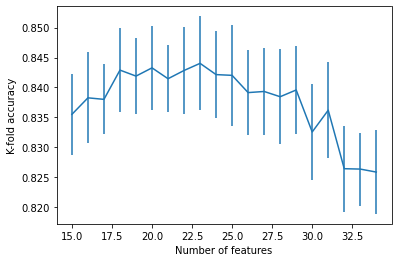

In [ ]:
plt.errorbar(x=nfeature_list, y=acc_feature_list.mean(axis=1), yerr=acc_feature_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("Number of features");
plt.ylabel("K-fold accuracy");

In [ ]:
n_opt=nfeature_list[np.argmax(acc_feature_list.mean(axis=1))]
print(n_opt)

23


In [ ]:
# According to the K-fold CV, these are the features we should use to fit our model:
keep_columns = cols[np.argsort(col_weights)[-n_opt:]]
keep_columns

Index(['MARRIED_Yes', 'ISSUE16_Immigration', 'RELIGN10_Protestant', 'ATTEND16',
       'RELIGN10_None', 'QLT16_Has good judgment', 'LIFE', 'TRADE16',
       'RACE_Black', 'RACE_White', 'FINSIT', 'GOVTANGR16',
       'QLT16_Has the right experience',
       'GOVTDO10_Government should do more to solve problems', 'NEC',
       'GOVTDO10_Government is doing too many things better left to businesses and individuals',
       'ISIS16', 'TRACK_Generally going in the right direction',
       'QLT16_Can bring needed change',
       'TRACK_Seriously off on the wrong track', 'IMMWALL_Support',
       'IMMWALL_Oppose', 'HEALTHCARE16'],
      dtype='object')

In [ ]:
X_trans = X[keep_columns]
X_trans.describe()

,MARRIED_Yes,ISSUE16_Immigration,RELIGN10_Protestant,ATTEND16,RELIGN10_None,QLT16_Has good judgment,LIFE,TRADE16,RACE_Black,RACE_White,FINSIT,GOVTANGR16,QLT16_Has the right experience,GOVTDO10_Government should do more to solve problems,NEC,GOVTDO10_Government is doing too many things better left to businesses and individuals,ISIS16,TRACK_Generally going in the right direction,QLT16_Can bring needed change,TRACK_Seriously off on the wrong track,IMMWALL_Support,IMMWALL_Oppose,HEALTHCARE16
count,8793.000000,8989.000000,7667.000000,4230.000000,7667.000000,8989.000000,4360.000000,4228.000000,22488.000000,22488.000000,4307.000000,4553.000000,8989.000000,4429.000000,4448.000000,4429.000000,4170.000000,4319.000000,8989.000000,4319.000000,4365.000000,4365.000000,4240.000000
mean,0.589332,0.116921,0.232686,0.538455,0.148298,0.189899,0.552867,0.485691,0.133093,0.707844,0.530532,0.394392,0.225609,0.470084,0.593825,0.480018,0.424620,0.358648,0.407164,0.605233,0.408935,0.549828,0.429953
std,0.491983,0.321344,0.422571,0.385464,0.355418,0.392243,0.426003,0.471166,0.339683,0.454764,0.386649,0.284469,0.418006,0.499161,0.265140,0.499657,0.305561,0.479659,0.491333,0.488857,0.491694,0.497568,0.442013
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.500000,0.500000,0.000000,1.000000,0.500000,0.333333,0.000000,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,1.000000,0.000000,1.000000,0.500000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.666667,0.000000,1.000000,0.666667,1.000000,0.666667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X_trans.shape

(22798, 23)

Let's look at test set performance with that feature subset (just to look - we're not going to make decisions based on the result!!!):

In [ ]:
distances_custom = np.zeros(shape=(len(idx_ts), len(idx_tr)))
for idx in tqdm(range(len(idx_ts)),  total=len(idx_ts), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X_trans.iloc[idx_ts[idx]], X_trans.iloc[idx_tr])

Distance matrix: 100%|██████████| 6840/6840 [01:33<00:00, 72.85it/s]


In [ ]:
r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:best_k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.8429824561403508

I will proceed using the MI score for feature weighting, so this is the final result of my feature selection/weighting:

In [ ]:
# of the options I showed, I'll use the MI feature weighting approach
# so, go back to that!
X_trans = X.multiply(col_weights)

In [ ]:
X_trans.describe(include='all')

#### To Do 7: Describe your feature selection/weighting and justify your design choices

Explain your approach to feature selection or feature weighting. What did you do in this section? Why do you think this was a good choice for this problem? 

For full credit, you must show that your design decisions are supported by the data.

Were the results of the feature selection of feature weighting procedure surprising or unexpected in any way?



---

Let's "sanity check" by looking at the count of values for each feature relative to presidential vote, and checking whether the results are consistent with the learned column weights.

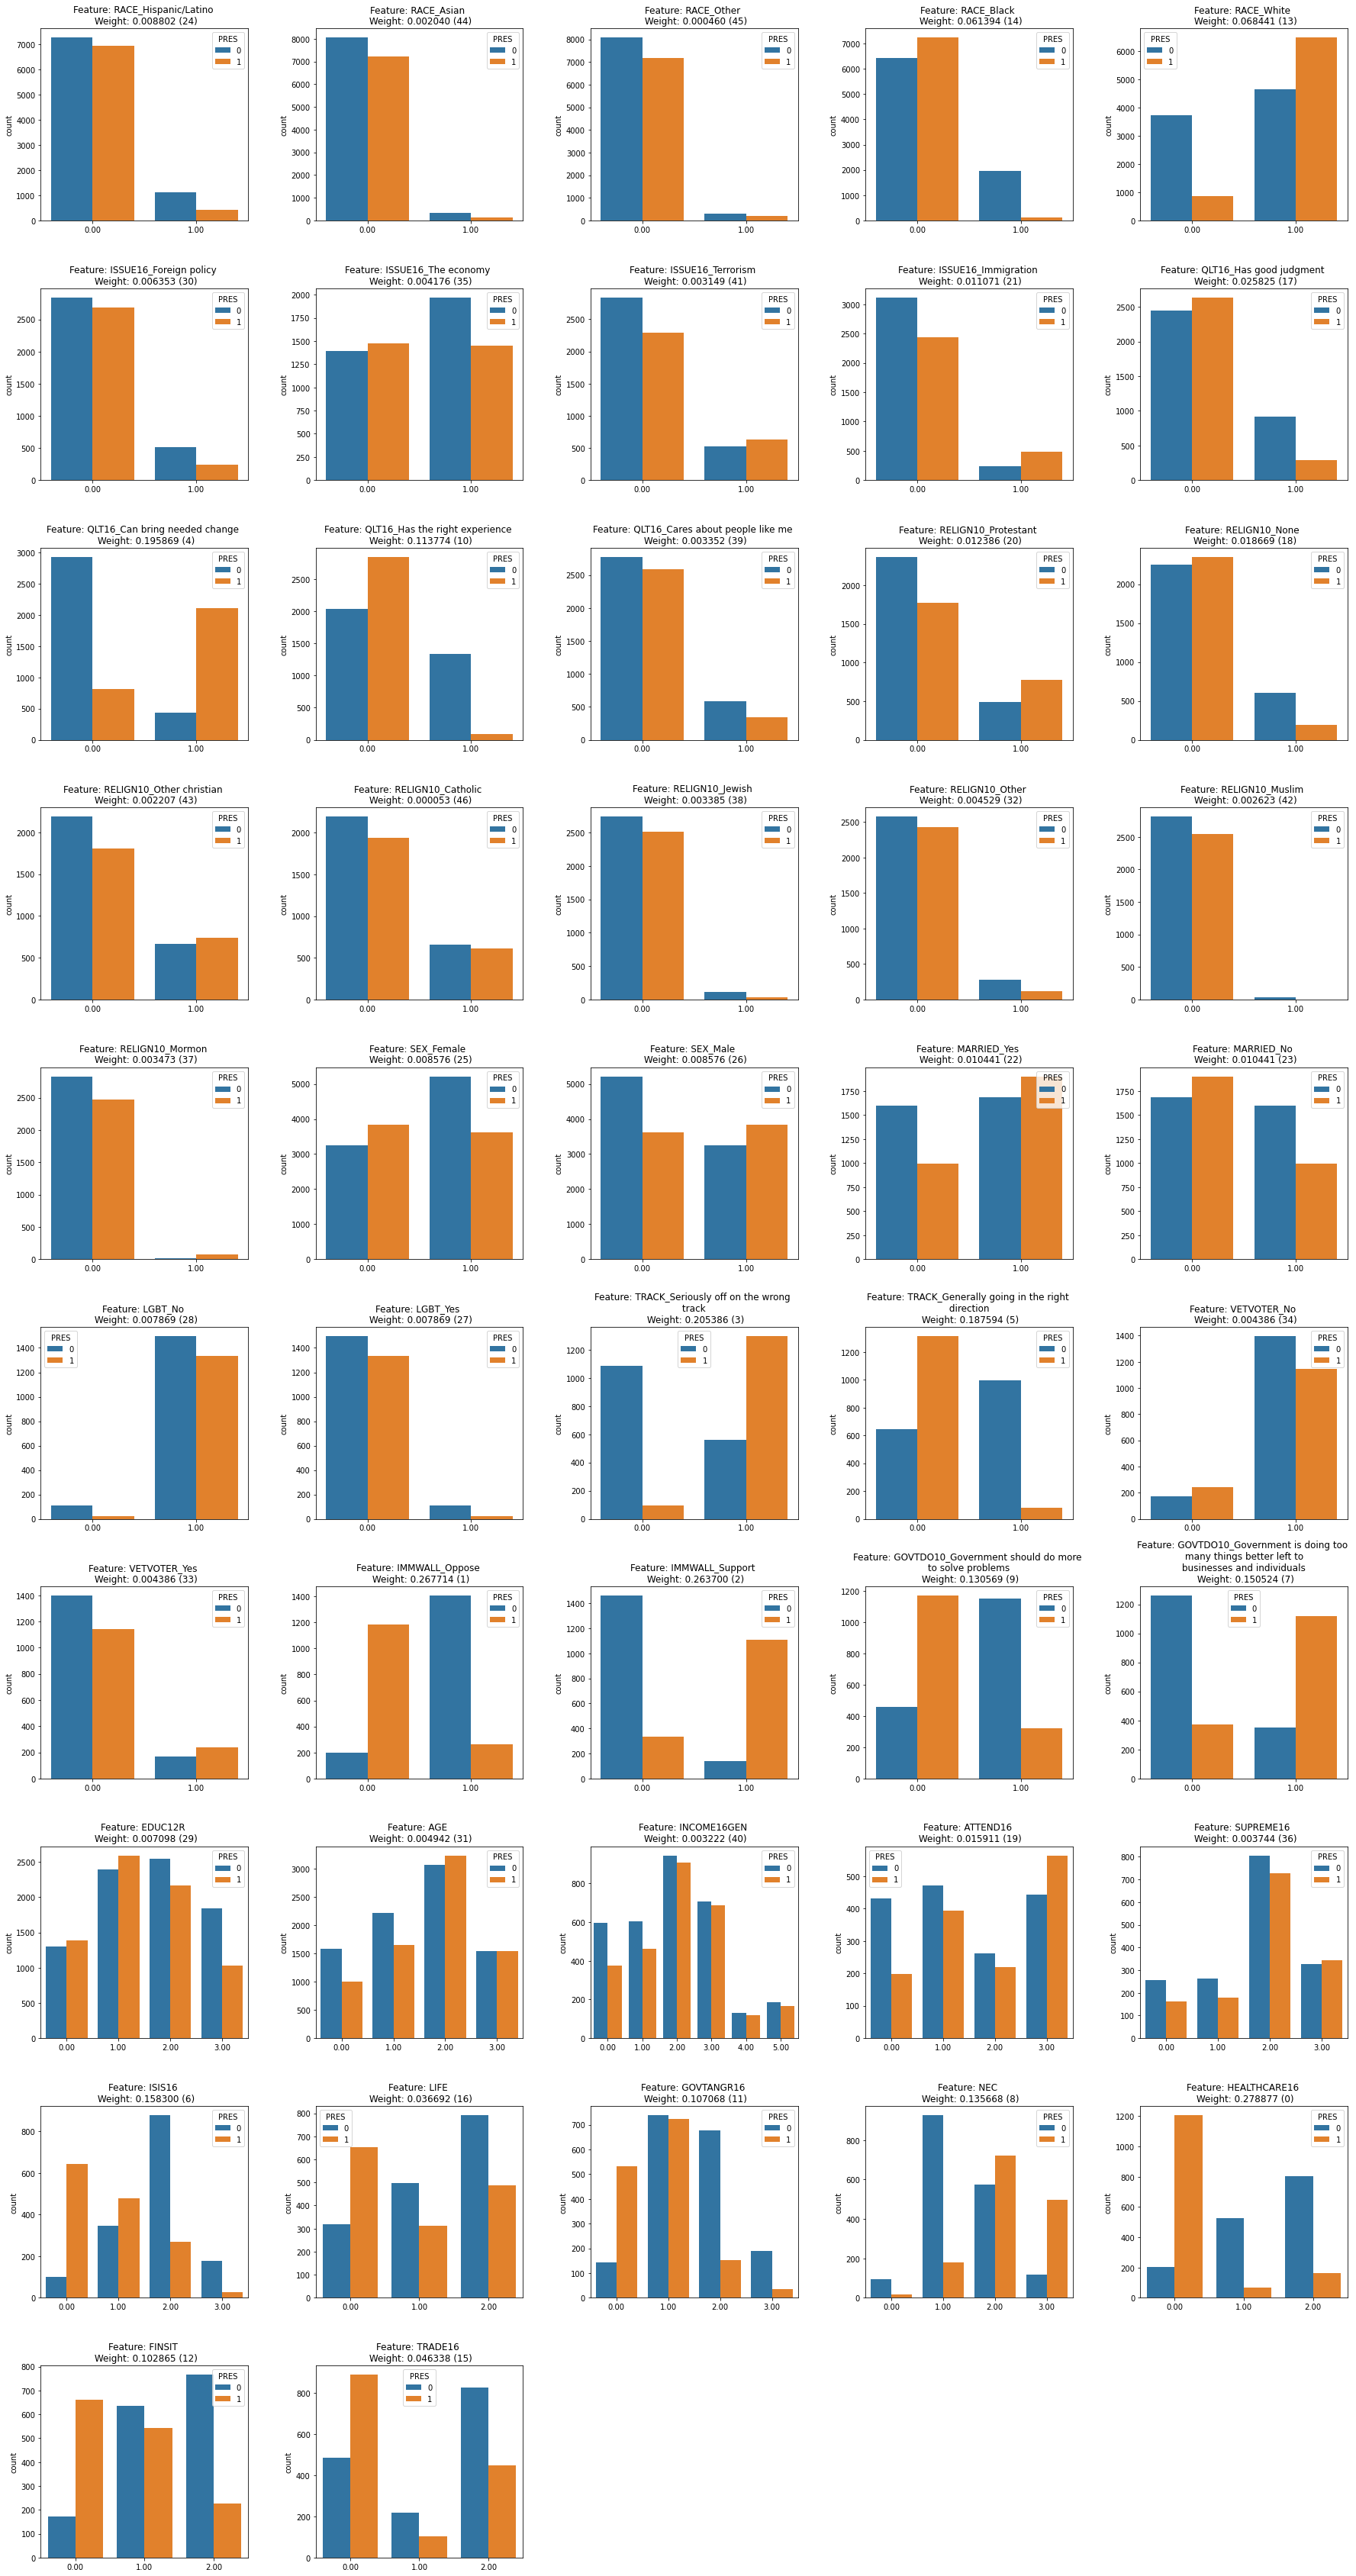

In [ ]:
from textwrap import wrap
titles = [" \n ".join(wrap(t, 35)) for t in X.columns]

# column "rank" in ascending order, i.e. columnn with highest weight has rank 0
ranks = col_weights.argsort()[::-1].argsort() 

fig = plt.figure(figsize=(25, np.ceil(len(X.columns))))

for idx, f in enumerate(X.columns):
    ax = fig.add_subplot(np.ceil(len(X.columns)/5.0), 5,idx+1)
    sns.countplot(x=X.iloc[idx_tr][f], hue=y.iloc[idx_tr], ax=ax)
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f')) 
    ax.set_title("Feature: %s \n Weight: %f (%d)" % (titles[idx], col_weights[idx], ranks[idx]))
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

The column weights seem to satisfy common sense.

* We can see that features where there is a big different in opinion between Trump voters and Clinton voters, like `HEALTHCARE16` and `IMMWALL`, have the highest weights. Those features are most useful for classification, so they should count more toward the distance computation.
* Features where there is not much difference between Trump voters and Clinton voters, such as whether or not the voter is Catholic, have the lowest weights.

#### Compare our MI score to other scoring methods

Just to see how it works, let's look at the column rank of the MI score compared to the column rank of other potential scoring metrics.

In [ ]:
# We mentioned chi2 earlier - let's try that
from sklearn.feature_selection import chi2

cols = X.columns
col_weights_chi2 = np.zeros(cols.shape[0])
for idx, c in enumerate(cols):
  df_col = pd.concat([X.iloc[idx_tr][c], y.iloc[idx_tr]], axis=1).dropna()
  col_weights_chi2[idx] = chi2(np.array(df_col[c]).reshape(-1,1), df_col['PRES'])[0]
ranks_chi2 = col_weights_chi2.argsort()[::-1].argsort() 

In [ ]:
# We can also try f_classif
from sklearn.feature_selection import f_classif

cols = X.columns
col_weights_f = np.zeros(cols.shape[0])
for idx, c in enumerate(cols):
  df_col = pd.concat([X.iloc[idx_tr][c], y.iloc[idx_tr]], axis=1).dropna()
  col_weights_f[idx] = f_classif(np.array(df_col[c]).reshape(-1,1), df_col['PRES'])[0]
ranks_f = col_weights_f.argsort()[::-1].argsort() 

In [ ]:
# One approach to feature selection is to remove low-variance features. If 
# all samples have a similar value for a particular feature, it may not be very
# useful! However, this approach doesn't necessarily tell us whether the feature
# is relevant for predicting the *target* variable
col_weights_var = np.nanvar(X.iloc[idx_tr], axis=0)
ranks_var = col_weights_var.argsort()[::-1].argsort() 

In [ ]:
# Another approach is to look at correlation coefficient between each feature 
# and the target variable. This is a reasonable approach in many cases. However
# we can't detect non-linear associations using this approach. Since KNN can take
# advantage of non-linear relationships, we may miss out on some potential 
# performance gain by using the correlation coefficient.
import scipy.stats
cols = X.columns
col_weights_corr = np.zeros(cols.shape[0])
for idx, c in enumerate(cols):
  df_col = pd.concat([X.iloc[idx_tr][c], y.iloc[idx_tr]], axis=1).dropna()
  col_weights_corr[idx] = scipy.stats.pearsonr(df_col[c], df_col['PRES'])[0]
col_weights_corr = np.abs(col_weights_corr) # we care about absolute value, not direction
ranks_corr = col_weights_corr.argsort()[::-1].argsort() 

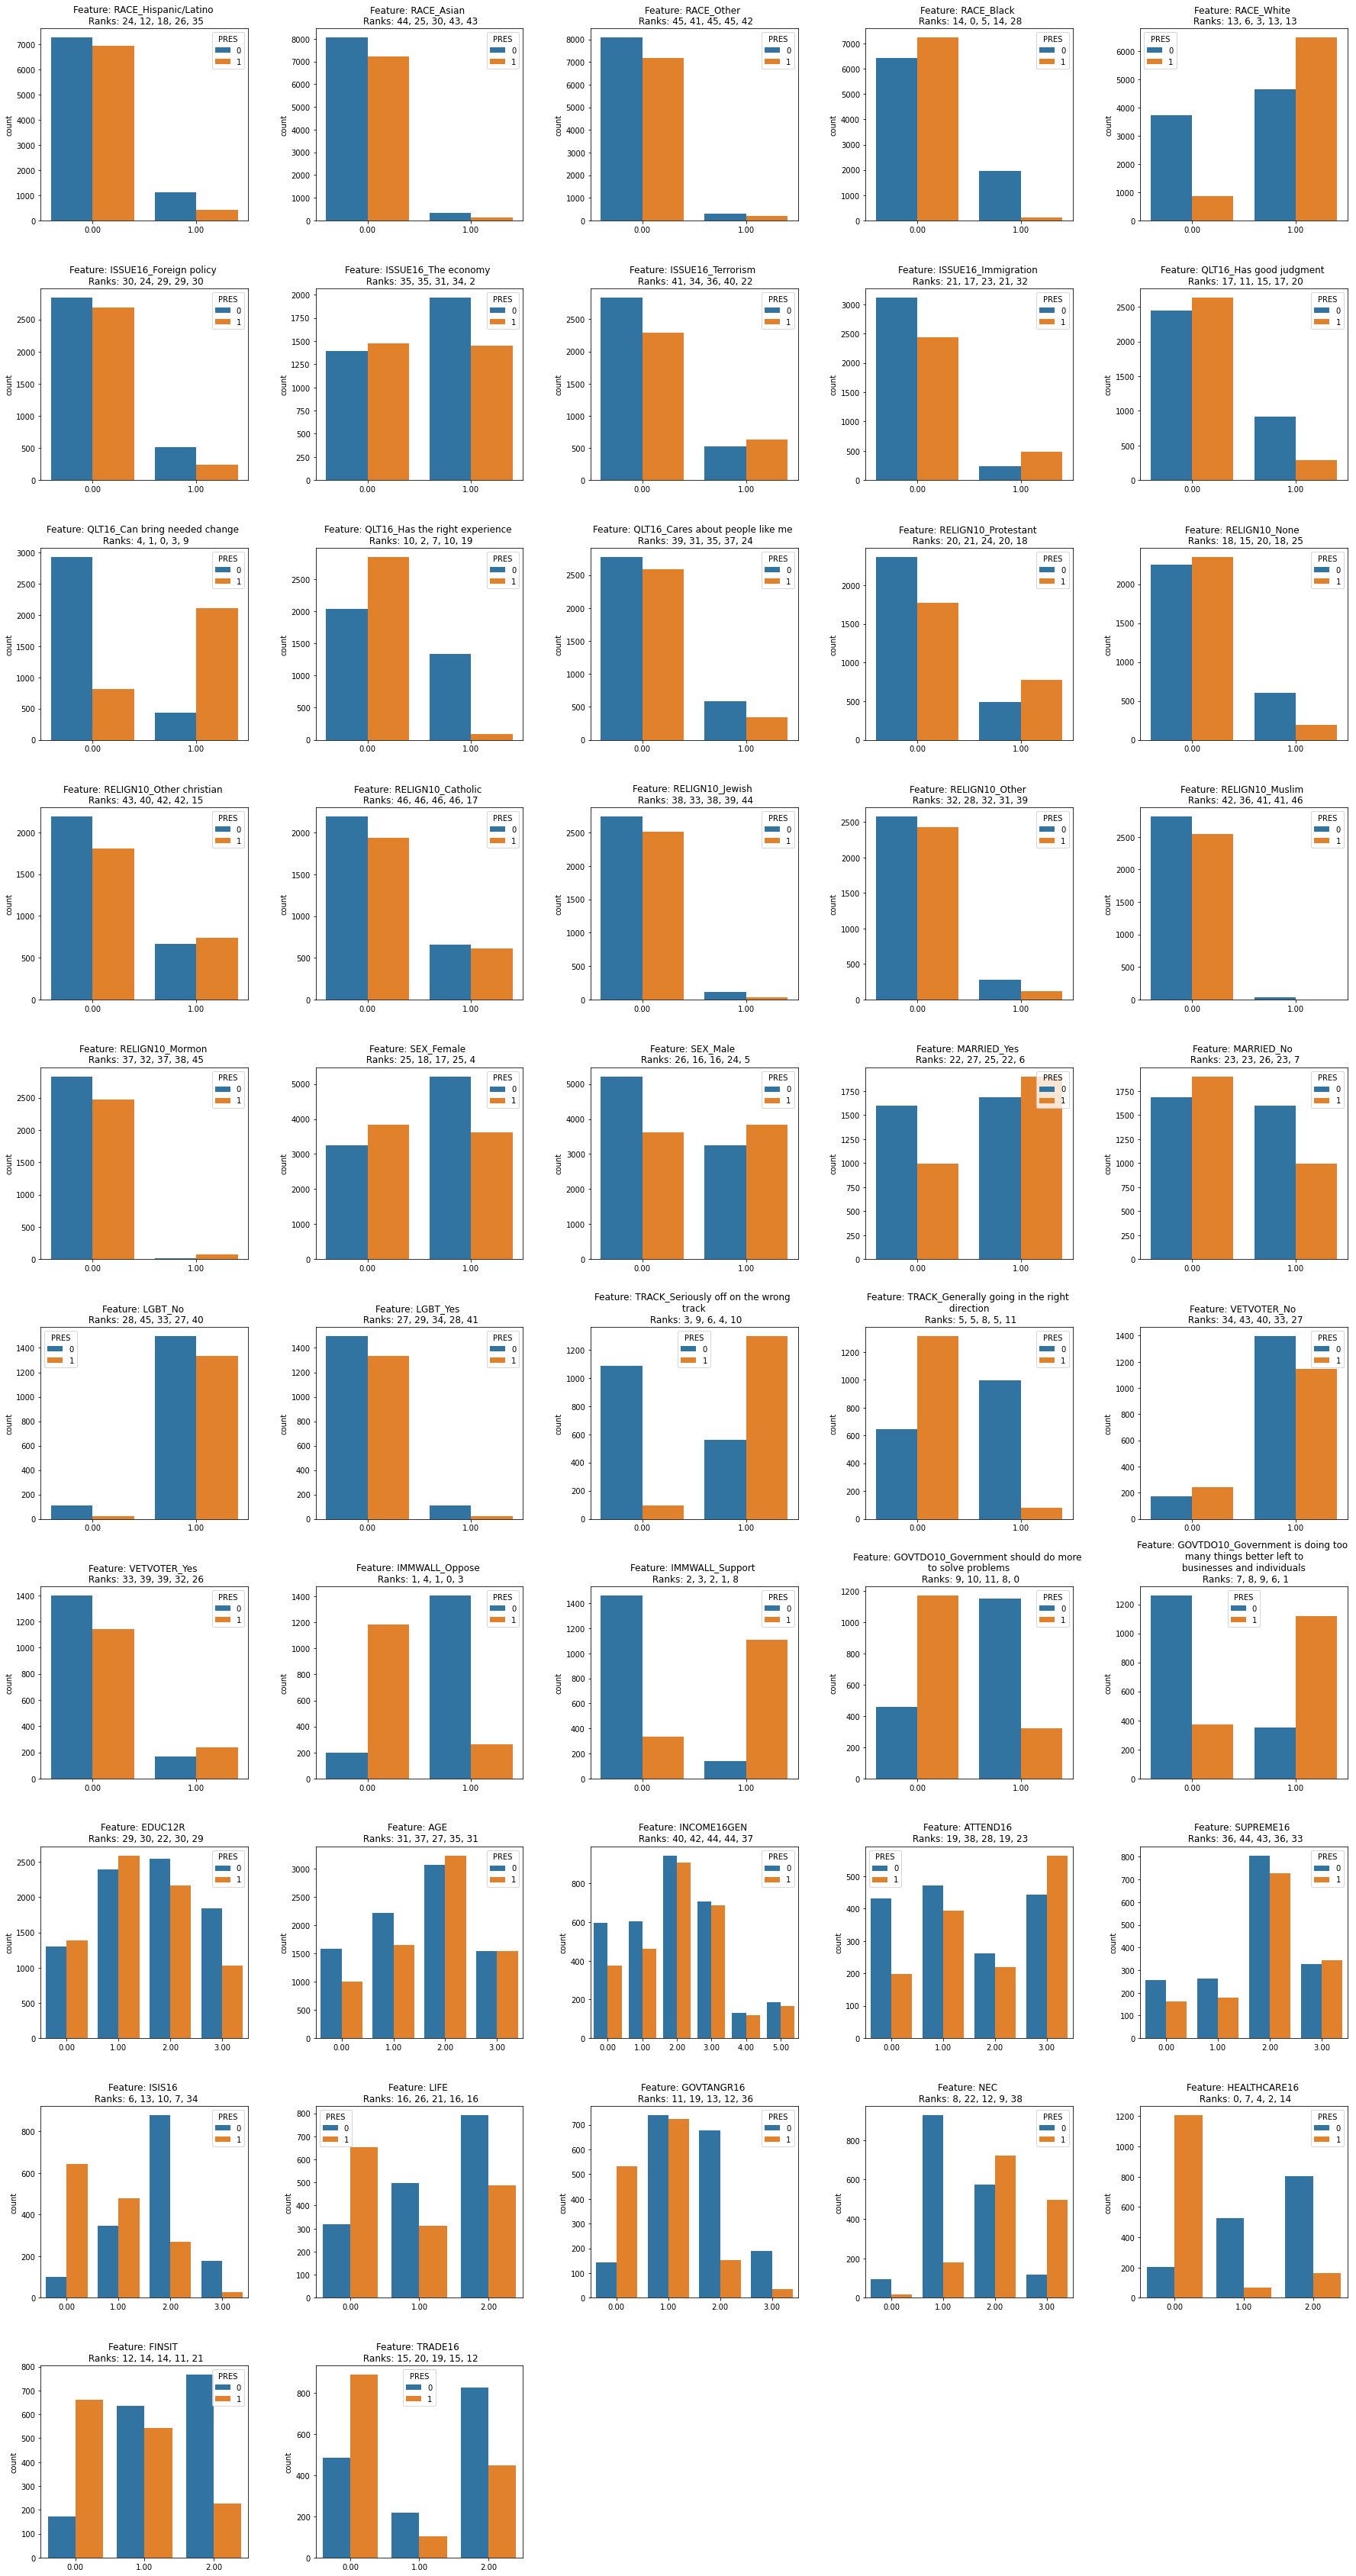

In [ ]:
from textwrap import wrap
titles = [" \n ".join(wrap(t, 35)) for t in X.columns]

# column "rank" in ascending order, i.e. columnn with highest weight has rank 0
ranks = col_weights.argsort()[::-1].argsort() 

fig = plt.figure(figsize=(25, np.ceil(len(X.columns))))

for idx, f in enumerate(X.columns):
    ax = fig.add_subplot(np.ceil(len(X.columns)/5.0), 5,idx+1)
    sns.countplot(x=X.iloc[idx_tr][f], hue=y.iloc[idx_tr], ax=ax)
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f')) 
    ax.set_title("Feature: %s \n Ranks: %d, %d, %d, %d, %d" % (titles[idx],  
                  ranks[idx], ranks_chi2[idx], ranks_f[idx], ranks_corr[idx], ranks_var[idx]))
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

In this image, the feature ranking according to each scoring metric is shown under the feature title, in the following order: 

mutual information, $\chi^2$, F-value, correlation with $y$, variance.

Notice that the variance metric does not detect whether a feature is related to the target variable or not, only whether there is variance among the samples. A variance score can be used to remove features that have almost no variance, but is not useful for deciding which features are most relevant to the target variable!

###  Evaluate your final classifier

Finally, train a K nearest neighbors classifier, using the approach shown earlier in this notebook, but with:

* your custom distance metric
* your feature matrix with additional ordinal-encoded and one-hot-encoded features, and the results of your feature selection or feature weighting



#### To Do 8: Select K (number of neighbors) for your final classifier

Once you have made your other design choices, you need to choose the value of K (the number of neighbors. 

For full credit, use cross validation to select K, and plot the mean validation accuracy for each candidate model.

If you can't use cross validation, you will get partial credit for selecting a reasonable value and justifying your choice. 

Make sure *not* to use your test set to determine the best K, since this is part of the training process.

In [ ]:
# TODO 8 - select the number of neighbors

In [ ]:
# Make sure to use X_trans and not X!!!!

from sklearn.model_selection import KFold

n_fold = 5
k_list = np.arange(1, 201, 5)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

kf = KFold(n_splits=5)

print(kf)

# pre-compute a distance matrix of training vs. training data
distances_kfold = np.zeros(shape=(len(idx_tr), len(idx_tr)))

for idx in range(len(idx_tr)):
  distances_kfold[idx] = custom_distance(X_trans.iloc[idx_tr[idx]], X_trans.iloc[idx_tr])

for isplit, idx_k in enumerate(kf.split(idx_tr)):

  print("Iteration %d" % isplit)

  # Outer loop: select training vs. validation data (out of training data!)
  idx_tr_k, idx_val_k = idx_k 

  # get target variable values for validation data
  y_val_kfold = y.iloc[idx_tr[idx_val_k]]

  # get distance matrix for validation set vs. training set
  distances_val_kfold   = distances_kfold[idx_val_k[:, None], idx_tr_k]

  # generate a random matrix for tie breaking
  r_matrix = np.random.random(size=(distances_val_kfold.shape))

  # loop over the rows of the distance matrix and the random matrix together with zip
  # for each pair of rows, return sorted indices from distances_val_kfold
  distances_sorted = np.array([np.lexsort((r, row)) for r, row in zip(r_matrix,distances_val_kfold)])

  # Inner loop: select value of K, number of neighbors
  for idx_k, k in enumerate(k_list):

    # now we select the indices of the K smallest, for different values of K
    # the indices in  distances_sorted are with respect to distances_val_kfold
    # from those - get indices in idx_tr_k, then in X
    nn_lists_idx = idx_tr[idx_tr_k[distances_sorted[:,:k]]]

    # get validation accuracy for this value of k
    y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
    acc_list[idx_k, isplit] = accuracy_score(y_val_kfold, y_pred)

KFold(n_splits=5, random_state=None, shuffle=False)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4


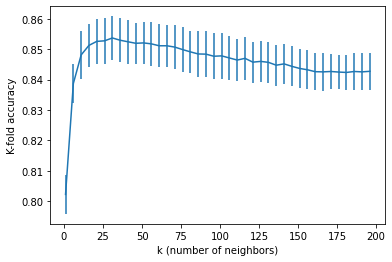

In [ ]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

In [ ]:
best_k = k_list[np.argmax(acc_list.mean(axis=1))]
print(best_k)

31


#### To Do 9: Evaluate your final classifier on the test set

Finally, evaluate the classifier accuracy on the test set. Print the test accuracy. Are you able to achieve at least 80% accuracy?

In [ ]:
# TODO 9 - Evaluate on test set

In [ ]:
distances_custom = np.zeros(shape=(len(idx_ts), len(idx_tr)))
distances_custom.shape

(6840, 15958)

In [ ]:
# Make sure to use X_trans and not X!!!!

for idx in tqdm(range(len(idx_ts)),  total=len(idx_ts), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X_trans.iloc[idx_ts[idx]], X_trans.iloc[idx_tr])

Distance matrix: 100%|██████████| 6840/6840 [02:24<00:00, 47.19it/s]


In [ ]:
# Make sure to use the latest best_k!!!!

r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:best_k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

0.8488304093567252